# Setup

In [13]:
import os
import re
import sys
from pathlib import Path
from collections import defaultdict

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from hassediagram.hasse_diagram import hasse_graphviz
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

sys.path.append(str(Path(os.getcwd()).parent))
from mcda.dataset import MCDADataset
from mcda.uta import Criterion, calculate_uta_gms, check_uta_feasibility, calculate_extreme_ranking
from mcda.smaa import calculate_pwi, calculate_rai, calculate_samples
from mcda.report import calculate_heuristics
from methods.autoencoder import DominanceAutoEncoder
from methods.mvu import MaximumVarianceUnfolding

sns.set()

In [14]:
def get_methods(n: int) -> dict:
    """
    Get a dictionary of methods for dimensionality reduction.

    Parameters
    ----------
    n (int): Number of components for the methods.

    Returns
    -------
    dict: Dictionary of methods.

    """
    return {
        "PCA": Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=n, random_state=42))]),
        "KernelPCA": Pipeline(
            [("scaler", StandardScaler()), ("kpca", KernelPCA(n_components=n, random_state=42, kernel="sigmoid"))]
        ),
        "Isomap": Pipeline([("scaler", StandardScaler()), ("isomap", Isomap(n_components=n))]),
        "MVU": Pipeline([("scaler", StandardScaler()), ("mvu", MaximumVarianceUnfolding(n_components=n, seed=42))]),
        "DAE": Pipeline(
            [
                ("scaler", StandardScaler()),
                ("dae", DominanceAutoEncoder(latent_dim=n, num_epochs=1000, random_state=42, verbose=False)),
            ]
        ),
    }

# Mapping number into lower indices

In [30]:
def convert_index_to_latex(sequence):
    latex_index = []
    for idx in sequence:
        match = re.match(r"^a(\d+)$", str(idx))
        if match:
            index = match.group(1)
            latex_index.append(f"$\\mathrm{{a}}_{{{index}}}$")
        else:
            latex_index.append(str(idx))

    return latex_index

def number_to_subscript(number):
    subscript_map = {'0': '₀', '1': '₁', '2': '₂', '3': '₃', '4': '₄',
                     '5': '₅', '6': '₆', '7': '₇', '8': '₈', '9': '₉'}
    return ''.join(subscript_map.get(digit, digit) for digit in str(number))

def convert_index_to_unicode(sequence):
    latex_index = []
    for idx in sequence:
        match = re.match(r"^a(\d+)$", str(idx))
        if match:
            index = match.group(1)
            latex_index.append(f"a{number_to_subscript(index)}")
        else:
            latex_index.append(str(idx))

    return latex_index

# DATASET

In [31]:
dataset: MCDADataset = MCDADataset.read_csv("../data/insulating-materials/dataset.csv")
df = dataset.data

# 2D PLOT

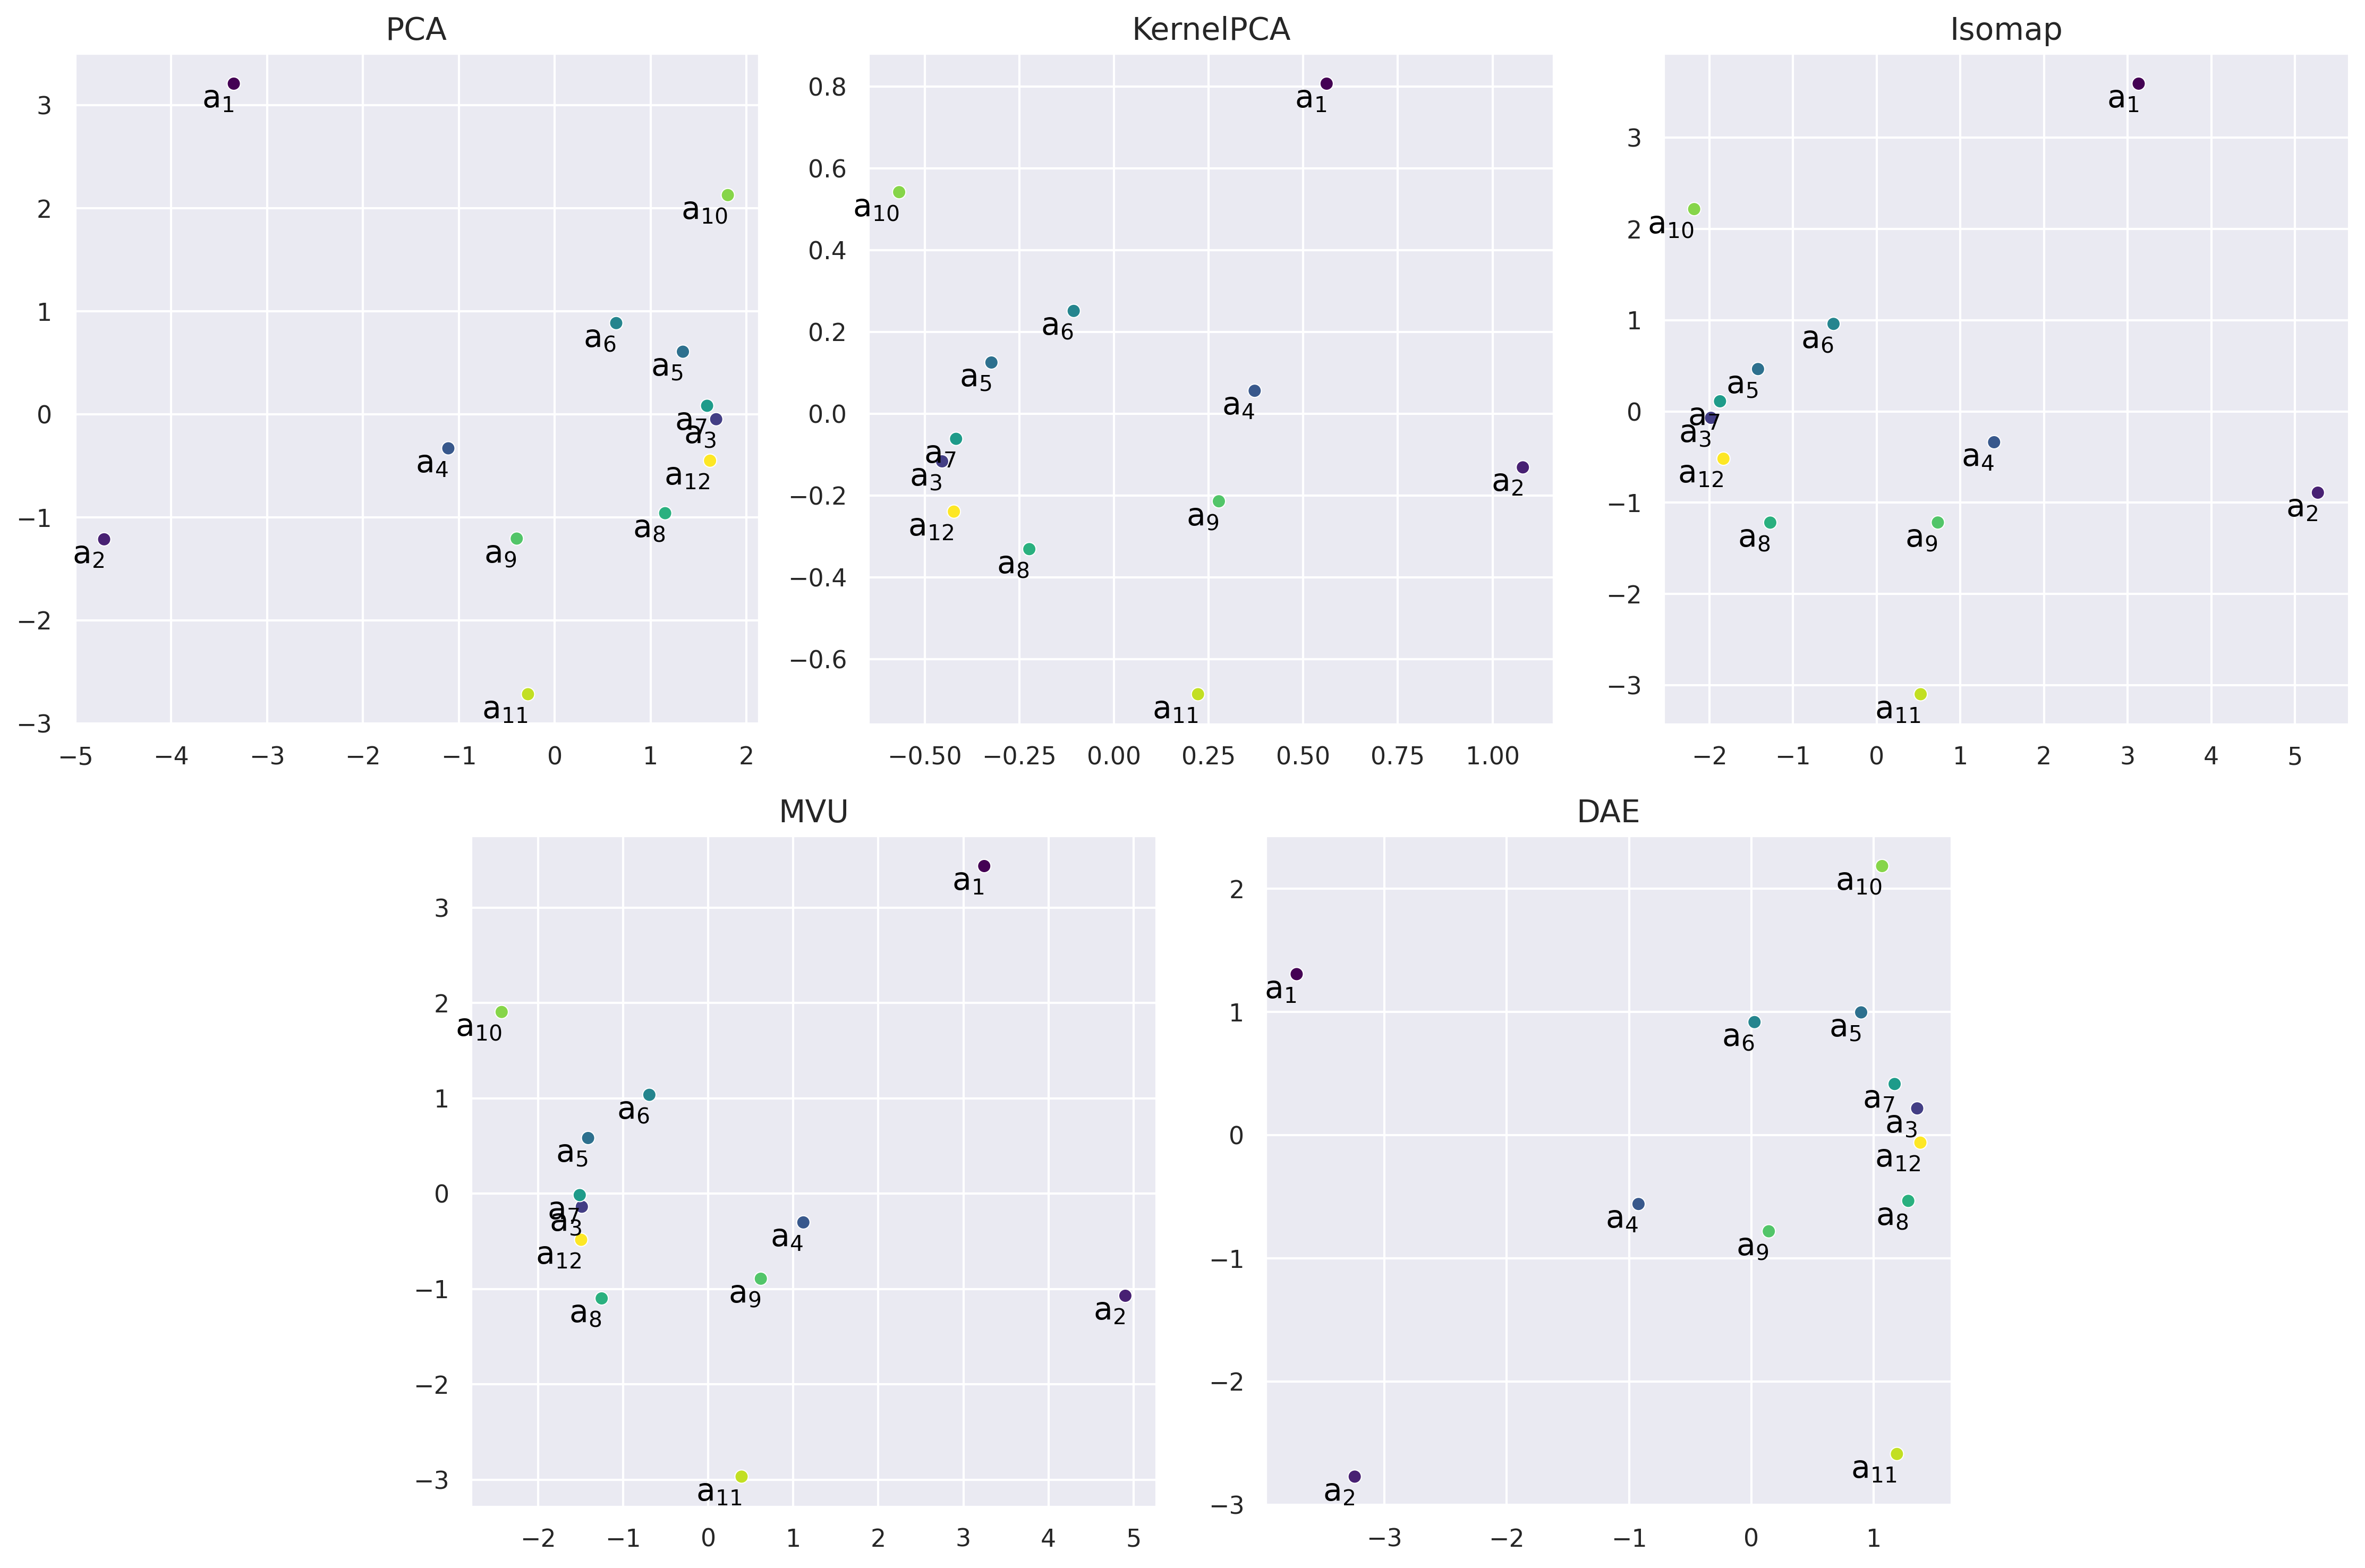

In [32]:
fig = plt.figure(figsize=(15, 10), dpi=300)

# Create a 2x6 grid (for finer control)
gs = gridspec.GridSpec(2, 6)
axes = []
axes.append(plt.subplot(gs[0, 0:2]))  # PCA spans columns 0-1
axes.append(plt.subplot(gs[0, 2:4]))  # KernelPCA spans columns 2-3
axes.append(plt.subplot(gs[0, 4:6]))  # Isomap spans columns 4-5
axes.append(plt.subplot(gs[1, 1:3]))  # MVU spans columns 1-2
axes.append(plt.subplot(gs[1, 3:5]))  # DAE spans columns 3-4

color = np.linspace(0, 1, df.shape[0])
methods = get_methods(2)
for i, (method_name, method) in enumerate(methods.items()):
    df_m = pd.DataFrame(method.fit_transform(df), index=df.index, columns=["Dim 1", "Dim 2"])
    sns.scatterplot(
        x="Dim 1",
        y="Dim 2",
        hue=color,
        palette="viridis",
        data=df_m,
        ax=axes[i],
        legend=False,
    )
    df_m_latex = df_m.copy()
    df_m_latex.index = convert_index_to_latex(df_m.index)
    for j in range(df_m_latex.shape[0]):
        axes[i].text(
            df_m_latex.iloc[j, 0],
            df_m_latex.iloc[j, 1],
            str(df_m_latex.index[j]),
            fontsize=14,
            color="black",
            ha="right",
            va="top",
        )
    axes[i].set_title(f"{method_name}", fontsize=14)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

plt.tight_layout()
plt.savefig("../data/insulating-materials/2d-plane.png")
plt.show()

# LATEX TABLE

## 2D

In [32]:
dfs = pd.DataFrame(index=df.index)
methods = get_methods(2)
for i, (method_name, method) in enumerate(methods.items()):
    df_m = pd.DataFrame(method.fit_transform(df), index=df.index, columns=["Dim 1", "Dim 2"])
    for col in df_m.columns:
        dfs[f"{method_name}_{col}"] = df_m[col]
dfs.columns = pd.MultiIndex.from_tuples([(x.split("_")[0], x.split("_")[1]) for x in dfs.columns])

latex_table = dfs.map(lambda x: f"{x:.3f}").to_latex(
    multicolumn=True,
    multicolumn_format="c",
    multirow=True,
    caption="Dimensionality Reduction Methods Comparison",
    label="tab:dim_reduction",
    column_format="|l|" + "r|" * 10,
)
print(latex_table)

\begin{table}
\caption{Dimensionality Reduction Methods Comparison}
\label{tab:dim_reduction}
\begin{tabular}{|l|r|r|r|r|r|r|r|r|r|r|}
\toprule
 & \multicolumn{2}{c}{PCA} & \multicolumn{2}{c}{KernelPCA} & \multicolumn{2}{c}{Isomap} & \multicolumn{2}{c}{MVU} & \multicolumn{2}{c}{DAE} \\
 & Dim 1 & Dim 2 & Dim 1 & Dim 2 & Dim 1 & Dim 2 & Dim 1 & Dim 2 & Dim 1 & Dim 2 \\
\midrule
a1 & -3.347 & 3.211 & 0.562 & 0.807 & 3.132 & 3.593 & 3.245 & 3.435 & -3.715 & 1.307 \\
a2 & -4.699 & -1.213 & 1.080 & -0.131 & 5.274 & -0.890 & 4.905 & -1.070 & -3.241 & -2.772 \\
a3 & 1.684 & -0.047 & -0.454 & -0.117 & -1.979 & -0.070 & -1.486 & -0.136 & 1.355 & 0.217 \\
a4 & -1.110 & -0.329 & 0.372 & 0.056 & 1.404 & -0.337 & 1.118 & -0.301 & -0.922 & -0.559 \\
a5 & 1.337 & 0.609 & -0.323 & 0.125 & -1.418 & 0.465 & -1.412 & 0.584 & 0.897 & 0.996 \\
a6 & 0.642 & 0.887 & -0.106 & 0.251 & -0.515 & 0.960 & -0.692 & 1.037 & 0.025 & 0.918 \\
a7 & 1.590 & 0.084 & -0.417 & -0.062 & -1.872 & 0.112 & -1.511 & -0.015 & 1.

## 3D

In [33]:
dfs = pd.DataFrame(index=df.index)
methods = get_methods(3)
for i, (method_name, method) in enumerate(methods.items()):
    df_m = pd.DataFrame(method.fit_transform(df), index=df.index, columns=["Dim 1", "Dim 2", "Dim 3"])
    for col in df_m.columns:
        dfs[f"{method_name}_{col}"] = df_m[col]
dfs.columns = pd.MultiIndex.from_tuples([(x.split("_")[0], x.split("_")[1]) for x in dfs.columns])
dfs = dfs[["PCA", "KernelPCA", "DAE"]]
latex_table = dfs.map(lambda x: f"{x:.3f}").to_latex(
    multicolumn=True,
    multicolumn_format="c|",
    multirow=True,
    caption="Dimensionality Reduction Methods Comparison",
    label="tab:dim_reduction",
    column_format="|l|" + "r|" * 10,
)
print(latex_table)

\begin{table}
\caption{Dimensionality Reduction Methods Comparison}
\label{tab:dim_reduction}
\begin{tabular}{|l|r|r|r|r|r|r|r|r|r|r|}
\toprule
 & \multicolumn{3}{c|}{PCA} & \multicolumn{3}{c|}{KernelPCA} & \multicolumn{3}{c|}{DAE} \\
 & Dim 1 & Dim 2 & Dim 3 & Dim 1 & Dim 2 & Dim 3 & Dim 1 & Dim 2 & Dim 3 \\
\midrule
a1 & -3.347 & 3.211 & -0.513 & 0.562 & 0.807 & 0.020 & -2.371 & 3.252 & 0.350 \\
a2 & -4.699 & -1.213 & 0.652 & 1.080 & -0.131 & -0.003 & -1.642 & 1.637 & -3.330 \\
a3 & 1.684 & -0.047 & -0.035 & -0.454 & -0.117 & 0.031 & 0.916 & -0.931 & 1.018 \\
a4 & -1.110 & -0.329 & 0.357 & 0.372 & 0.056 & -0.186 & -0.008 & 0.836 & -0.792 \\
a5 & 1.337 & 0.609 & 0.497 & -0.323 & 0.125 & -0.115 & 0.962 & -0.053 & 1.309 \\
a6 & 0.642 & 0.887 & -0.392 & -0.106 & 0.251 & 0.107 & -0.180 & 0.302 & 1.018 \\
a7 & 1.590 & 0.084 & -0.041 & -0.417 & -0.062 & 0.036 & 0.876 & -0.668 & 1.034 \\
a8 & 1.152 & -0.959 & -0.217 & -0.223 & -0.331 & -0.006 & 0.908 & -0.959 & 0.139 \\
a9 & -0.396 & -1.206 

# PCA explained variance

In [35]:
for n in [2, 3, 4, 5, 6]:
    pipeline = get_methods(n)["PCA"]
    transformed_data = pipeline.fit_transform(dataset.data)
    print(pipeline["pca"].explained_variance_ratio_, sum(pipeline["pca"].explained_variance_ratio_))

[0.58956614 0.32797924] 0.9175453771928339
[0.58956614 0.32797924 0.04579309] 0.9633384706594186
[0.58956614 0.32797924 0.04579309 0.02388217] 0.9872206397636945
[0.58956614 0.32797924 0.04579309 0.02388217 0.01132614] 0.9985467796624744
[0.58956614 0.32797924 0.04579309 0.02388217 0.01132614 0.00128782] 0.9998345952502118


# Preferences

In [29]:
preferences = {
    1: [
        [("a3", "a9")],
        [("a8", "a11")],
        [("a6", "a12")],
        [("a6", "a11")],
        [("a6", "a2")],
        [("a7", "a8")],
        [("a1", "a2")],
        [("a5", "a8")],
        [("a3", "a2")],
        [("a1", "a9")],
    ],
    2: [
        [("a3", "a9"), ("a1", "a9")],
        [("a8", "a11"), ("a4", "a2")],
        [("a6", "a12"), ("a5", "a8")],
        [("a6", "a11"), ("a1", "a4")],
        [("a6", "a2"), ("a10", "a5")],
        [("a7", "a8"), ("a1", "a11")],
        [("a1", "a2"), ("a1", "a7")],
        [("a5", "a8"), ("a12", "a8")],
        [("a3", "a2"), ("a6", "a4")],
        [("a1", "a9"), ("a3", "a4")],
    ],
    3: [
        [("a3", "a9"), ("a1", "a9"), ("a1", "a11")],
        [("a8", "a11"), ("a4", "a2"), ("a3", "a9")],
        [("a6", "a12"), ("a5", "a8"), ("a3", "a9")],
        [("a6", "a11"), ("a1", "a4"), ("a6", "a12")],
        [("a6", "a2"), ("a10", "a5"), ("a7", "a12")],
        [("a7", "a8"), ("a1", "a11"), ("a1", "a9")],
        [("a1", "a2"), ("a1", "a7"), ("a6", "a9")],
        [("a5", "a8"), ("a12", "a8"), ("a6", "a8")],
        [("a3", "a2"), ("a6", "a4"), ("a4", "a9")],
        [("a1", "a9"), ("a3", "a4"), ("a10", "a2")],
    ],
    4: [
        [("a3", "a9"), ("a1", "a9"), ("a1", "a11"), ("a1", "a8")],
        [("a8", "a11"), ("a4", "a2"), ("a3", "a9"), ("a6", "a11")],
        [("a6", "a12"), ("a5", "a8"), ("a3", "a9"), ("a4", "a11")],
        [("a6", "a11"), ("a1", "a4"), ("a6", "a12"), ("a10", "a3")],
        [("a6", "a2"), ("a10", "a5"), ("a7", "a12"), ("a5", "a7")],
        [("a7", "a8"), ("a1", "a11"), ("a1", "a9"), ("a12", "a11")],
        [("a1", "a2"), ("a1", "a7"), ("a6", "a9"), ("a1", "a6")],
        [("a5", "a8"), ("a12", "a8"), ("a6", "a8"), ("a6", "a3")],
        [("a3", "a2"), ("a6", "a4"), ("a4", "a9"), ("a4", "a11")],
        [("a1", "a9"), ("a3", "a4"), ("a10", "a2"), ("a12", "a2")],
    ],
    5: [
        [("a3", "a9"), ("a1", "a9"), ("a1", "a11"), ("a1", "a8"), ("a7", "a3")],
        [("a8", "a11"), ("a4", "a2"), ("a3", "a9"), ("a6", "a11"), ("a7", "a9")],
        [("a6", "a12"), ("a5", "a8"), ("a3", "a9"), ("a4", "a11"), ("a1", "a7")],
        [("a6", "a11"), ("a1", "a4"), ("a6", "a12"), ("a10", "a3"), ("a10", "a2")],
        [("a6", "a2"), ("a10", "a5"), ("a7", "a12"), ("a5", "a7"), ("a10", "a3")],
        [("a7", "a8"), ("a1", "a11"), ("a1", "a9"), ("a12", "a11"), ("a5", "a12")],
        [("a1", "a2"), ("a1", "a7"), ("a6", "a9"), ("a1", "a6"), ("a6", "a12")],
        [("a5", "a8"), ("a12", "a8"), ("a6", "a8"), ("a6", "a3"), ("a4", "a9")],
        [("a3", "a2"), ("a6", "a4"), ("a4", "a9"), ("a4", "a11"), ("a1", "a7")],
        [("a1", "a9"), ("a3", "a4"), ("a10", "a2"), ("a12", "a2"), ("a4", "a9")],
    ],
    6: [
        [("a3", "a9"), ("a1", "a9"), ("a1", "a11"), ("a1", "a8"), ("a7", "a3"), ("a4", "a2")],
        [("a8", "a11"), ("a4", "a2"), ("a3", "a9"), ("a6", "a11"), ("a7", "a9"), ("a1", "a9")],
        [("a6", "a12"), ("a5", "a8"), ("a3", "a9"), ("a4", "a11"), ("a1", "a7"), ("a7", "a11")],
        [("a6", "a11"), ("a1", "a4"), ("a6", "a12"), ("a10", "a3"), ("a10", "a2"), ("a4", "a9")],
        [("a6", "a2"), ("a10", "a5"), ("a7", "a12"), ("a5", "a7"), ("a10", "a3"), ("a3", "a8")],
        [("a7", "a8"), ("a1", "a11"), ("a1", "a9"), ("a12", "a11"), ("a5", "a12"), ("a1", "a5")],
        [("a1", "a2"), ("a1", "a7"), ("a6", "a9"), ("a1", "a6"), ("a6", "a12"), ("a1", "a5")],
        [("a5", "a8"), ("a12", "a8"), ("a6", "a8"), ("a6", "a3"), ("a4", "a9"), ("a5", "a4")],
        [("a3", "a2"), ("a6", "a4"), ("a4", "a9"), ("a4", "a11"), ("a1", "a7"), ("a3", "a8")],
        [("a1", "a9"), ("a3", "a4"), ("a10", "a2"), ("a12", "a2"), ("a4", "a9"), ("a4", "a2")],
    ],
}

# Diagram for the original dataset

In [38]:
for preference in [l[0] for l in preferences.values()]:
    number_of_preference = len(preference)
    df_utagms = calculate_uta_gms(dataset.data, preference, dataset.criteria)
    dot = hasse_graphviz(df_utagms.values, labels=convert_index_to_unicode(df_utagms.index))
    dot.graph_attr.update(dpi="300")
    dot.render(
        filename="original",
        directory=f"../data/insulating-materials/output-dataset/preferences_{number_of_preference}/diagrams",
        format="png",
        cleanup=True,
    )

# Generating diagrams

In [39]:
for preference in [l[0] for l in preferences.values()]:
    number_of_preference = len(preference)
    for n in [2, 3, 4, 5, 6]:
        methods = get_methods(n)
        for method_name, method in methods.items():
            transformed_data = method.fit_transform(dataset.data)
            df_m = (
                pd.DataFrame(transformed_data, index=dataset.data.index, columns=range(n))
                .map(lambda x: f"{x:.4f}")
                .astype(np.float64)
            )
            criteria = [Criterion(name, points=2) for name in df_m.columns]
            df_utagms = calculate_uta_gms(df_m, preference, criteria)
            dot = hasse_graphviz(df_utagms.values, labels=convert_index_to_unicode(df_utagms.index))
            dot.graph_attr.update(dpi="300")
            dot.render(
                filename=method_name,
                directory=f"../data/insulating-materials/output-dataset/preferences_{number_of_preference}/diagrams/dim_{n}",
                format="png",
                cleanup=True,
            )

# Counting the f_NEC

In [6]:
for n in [2, 3]:
    # Calculations
    pca = get_methods(n)["PCA"]
    transformed_data = pca.fit_transform(dataset.data)
    df_m = (
        pd.DataFrame(transformed_data, index=dataset.data.index, columns=range(n))
        .map(lambda x: f"{x:.4f}")
        .astype(np.float64)
    )    
    criteria = [Criterion(name, points=2) for name in df_m.columns]
    df_utagms = calculate_uta_gms(df_m, preferences[6][0], criteria)
    np.fill_diagonal(df_utagms.values, 0)
    print(f"For {n} and PCA f_NEC = {df_utagms.sum().sum()}")

For 2 and PCA f_NEC = 54
For 3 and PCA f_NEC = 39


# Visualization of ERA

For 2 and PCA f_ERA = 1.8333333333333333


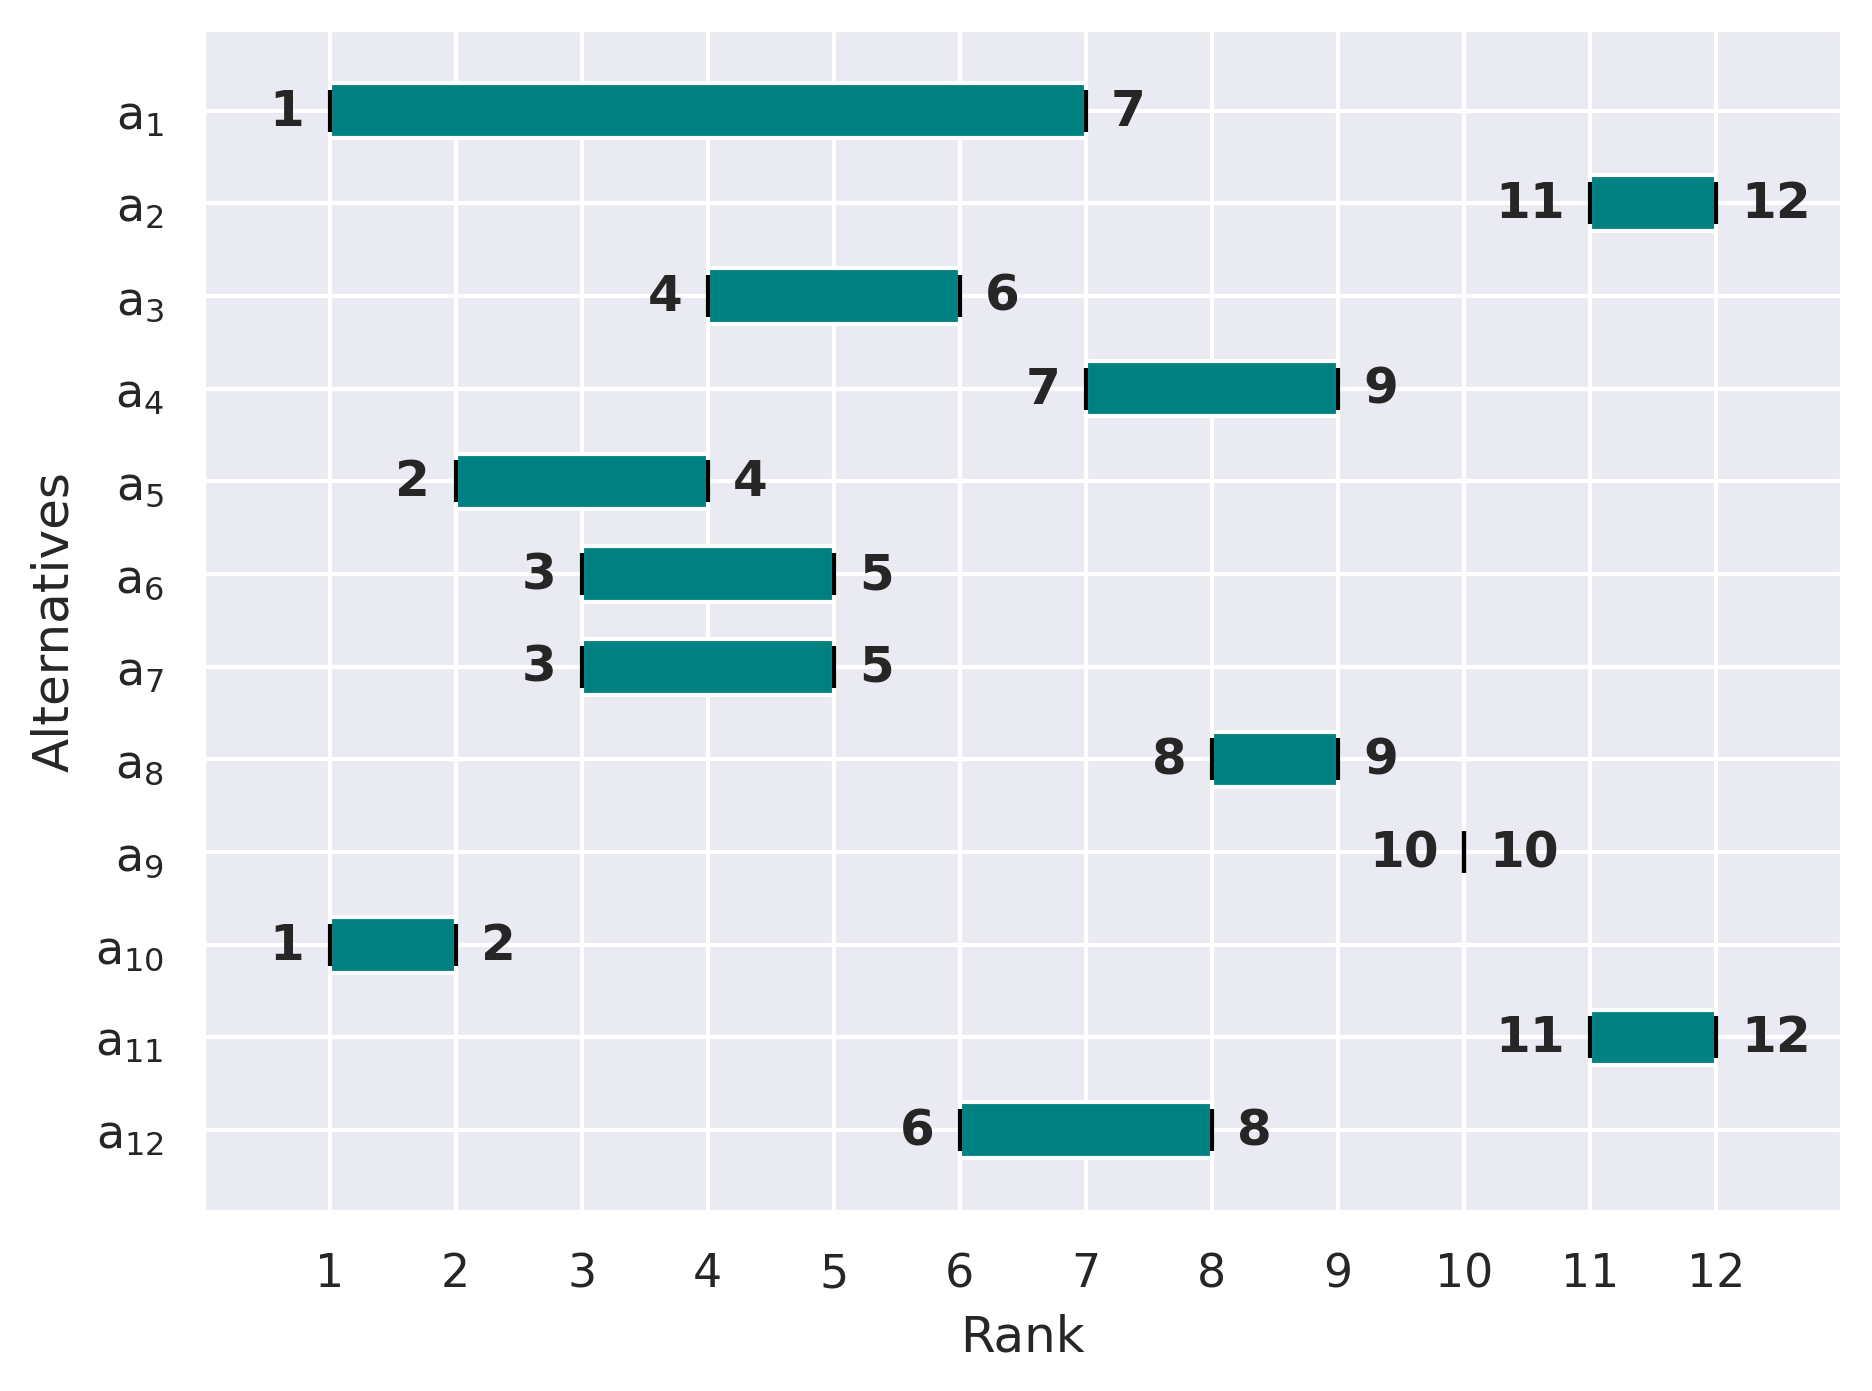

For 3 and PCA f_ERA = 4.333333333333333


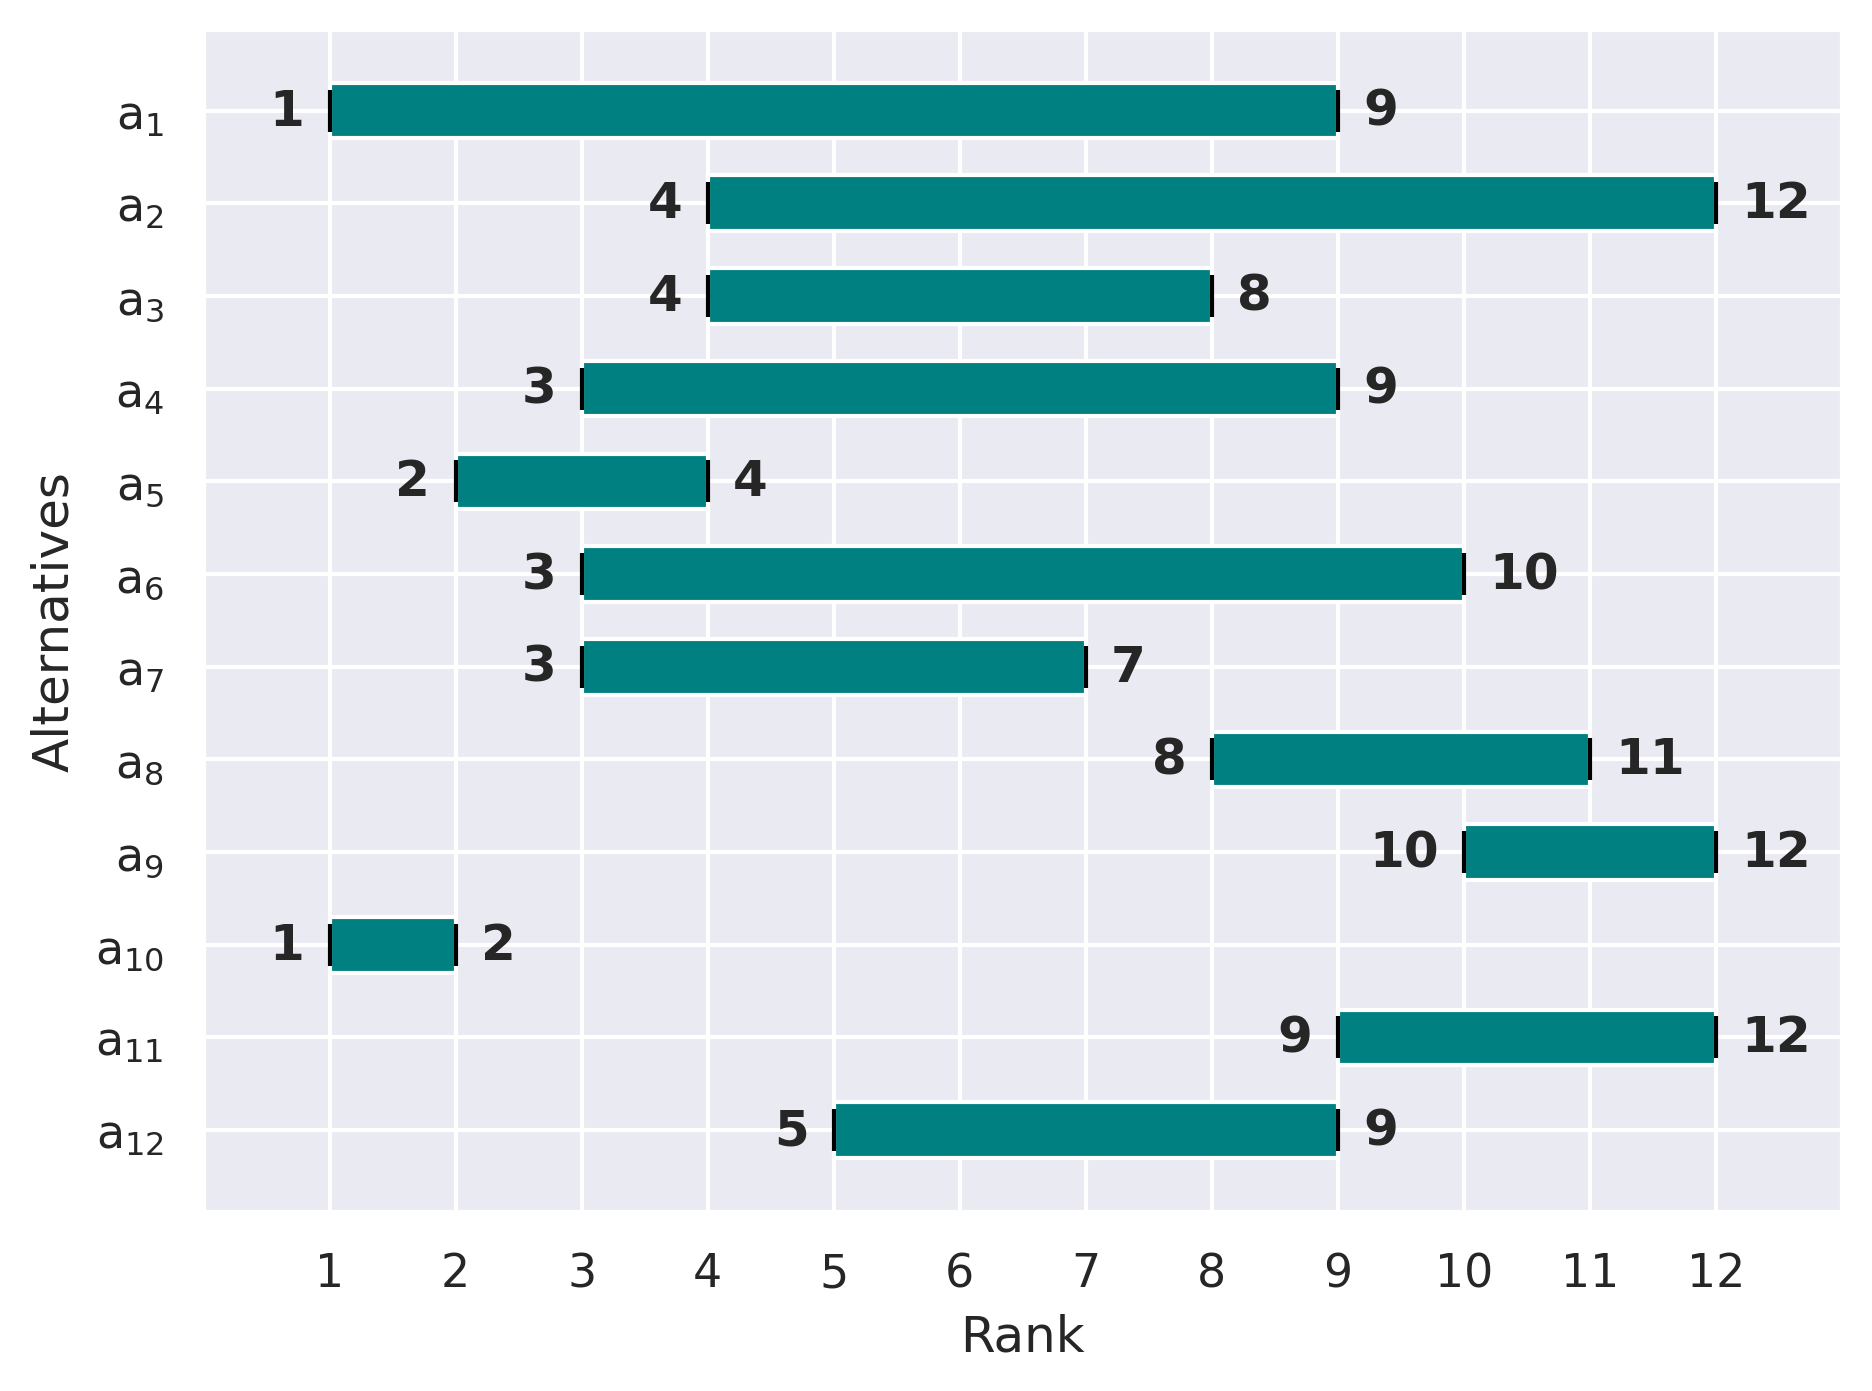

In [41]:
for n in [2, 3]:
    
    # Calculations
    pca = get_methods(n)["PCA"]
    transformed_data = pca.fit_transform(dataset.data)
    df_m = (
        pd.DataFrame(transformed_data, index=dataset.data.index, columns=range(n))
        .map(lambda x: f"{x:.4f}")
        .astype(np.float64)
    )    
    criteria = [Criterion(name, points=2) for name in df_m.columns]
    df_extreme = calculate_extreme_ranking(df_m, preferences[6][0], criteria)
    df_extreme = df_extreme.reset_index(names=["label"])
    df_extreme["range_length"] = df_extreme["worst"] - df_extreme["best"]
    df_extreme.sort_index(ascending=False, inplace=True)
    print(f"For {n} and PCA f_ERA = {(df_extreme["worst"] - df_extreme["best"]).mean()}")

    # Plotting
    plt.figure(dpi=300)
    plt.barh(
        y=np.arange(len(df_extreme['label'])), 
        width=df_extreme['range_length'],
        left=df_extreme['best'],
        height=0.6,
        color="teal"
    )
    
    # Markers for start and end points
    for i, (_, row) in enumerate(df_extreme.iterrows()):
        plt.plot(row['best'], i, '|', color='black', markersize=10)
        plt.plot(row['worst'], i, '|', color='black', markersize=10)
    # Text for start and end points
    for i, (_, row) in enumerate(df_extreme.iterrows()):
        plt.text(row['best'] - 0.2, i, str(row['best']), va='center', ha='right', fontweight='bold')
        plt.text(row['worst'] + 0.2, i, str(row['worst']), va='center', ha='left', fontweight='bold')

    # Configuring the axes
    plt.yticks(
        np.arange(len(df_extreme['label'])), 
        convert_index_to_latex(df_extreme["label"])
    )
    plt.xlim(0, len(df_extreme)+1)
    plt.xticks(range(1, len(df_extreme)+1))
    plt.xlabel('Rank')
    plt.ylabel('Alternatives')

    plt.tight_layout()
    path = Path("../data/insulating-materials/output-dataset/preferences_6/plots/era")
    path.mkdir(exist_ok=True)
    plt.savefig(path / f"{n}dim_PCA")
    plt.show()

# Visualization of PWI

For 2 and PCA f_PWI = 0.05112651515151515


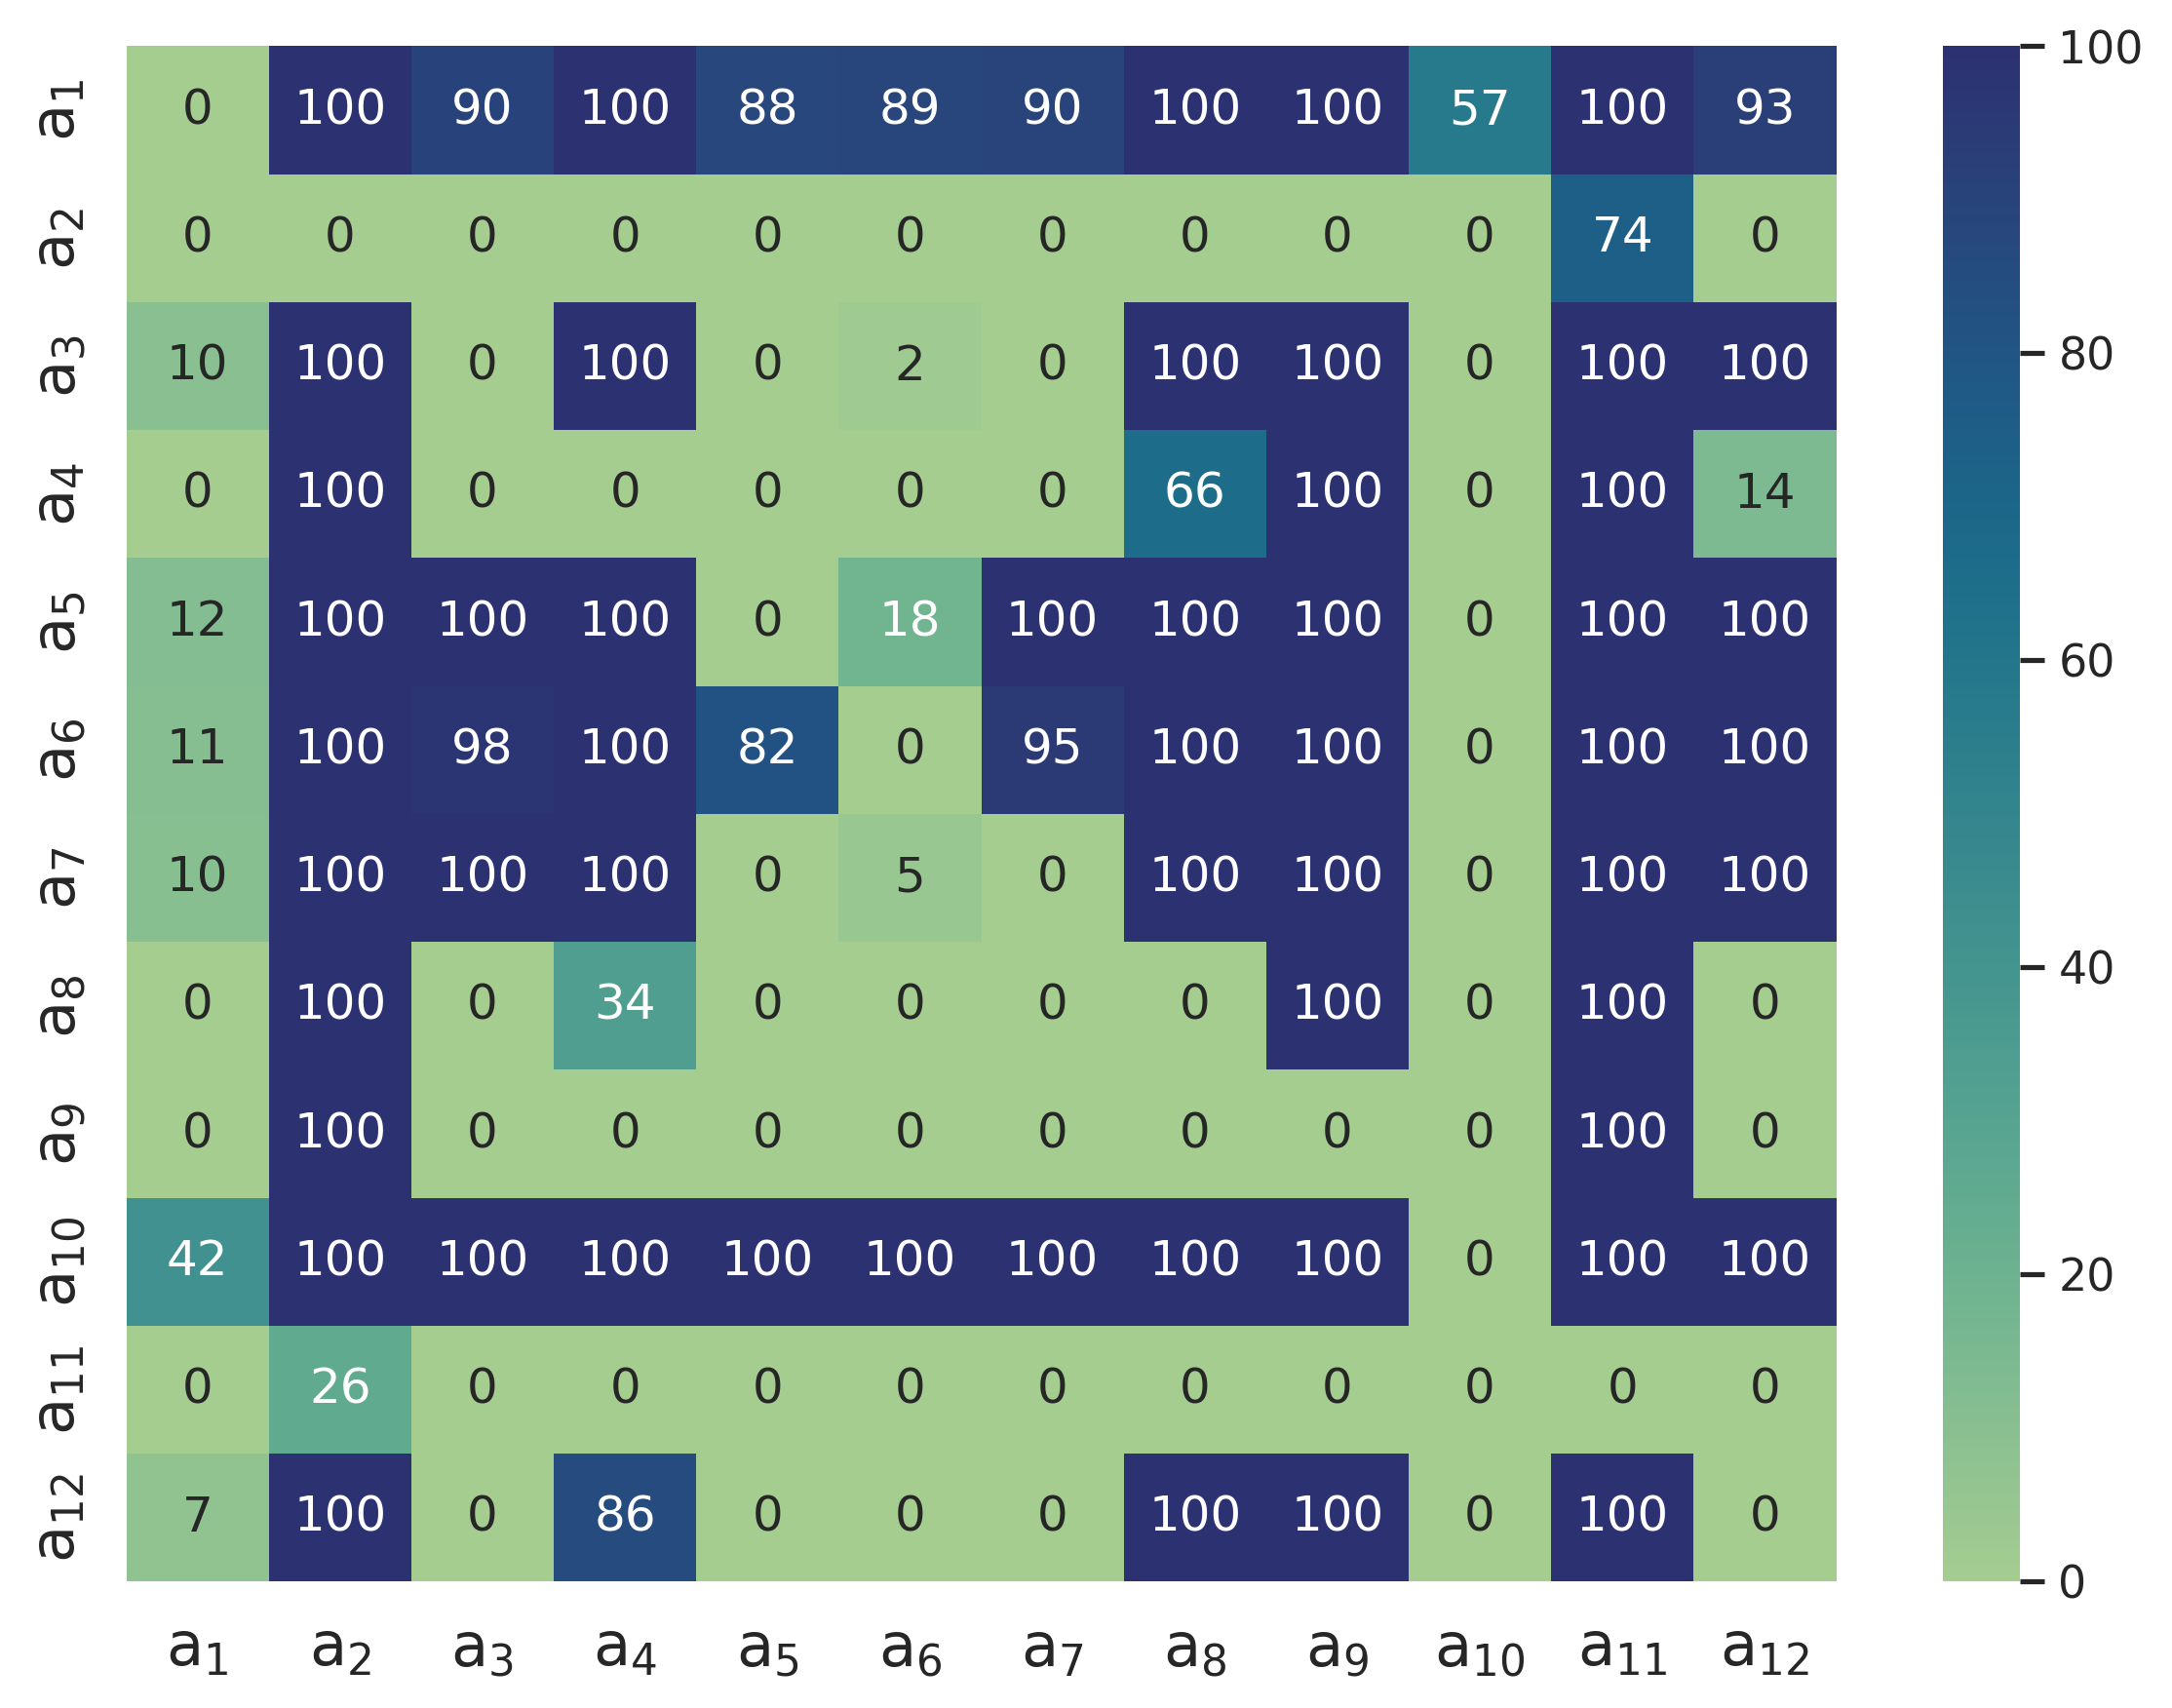

For 3 and PCA f_PWI = 0.11526136363636366


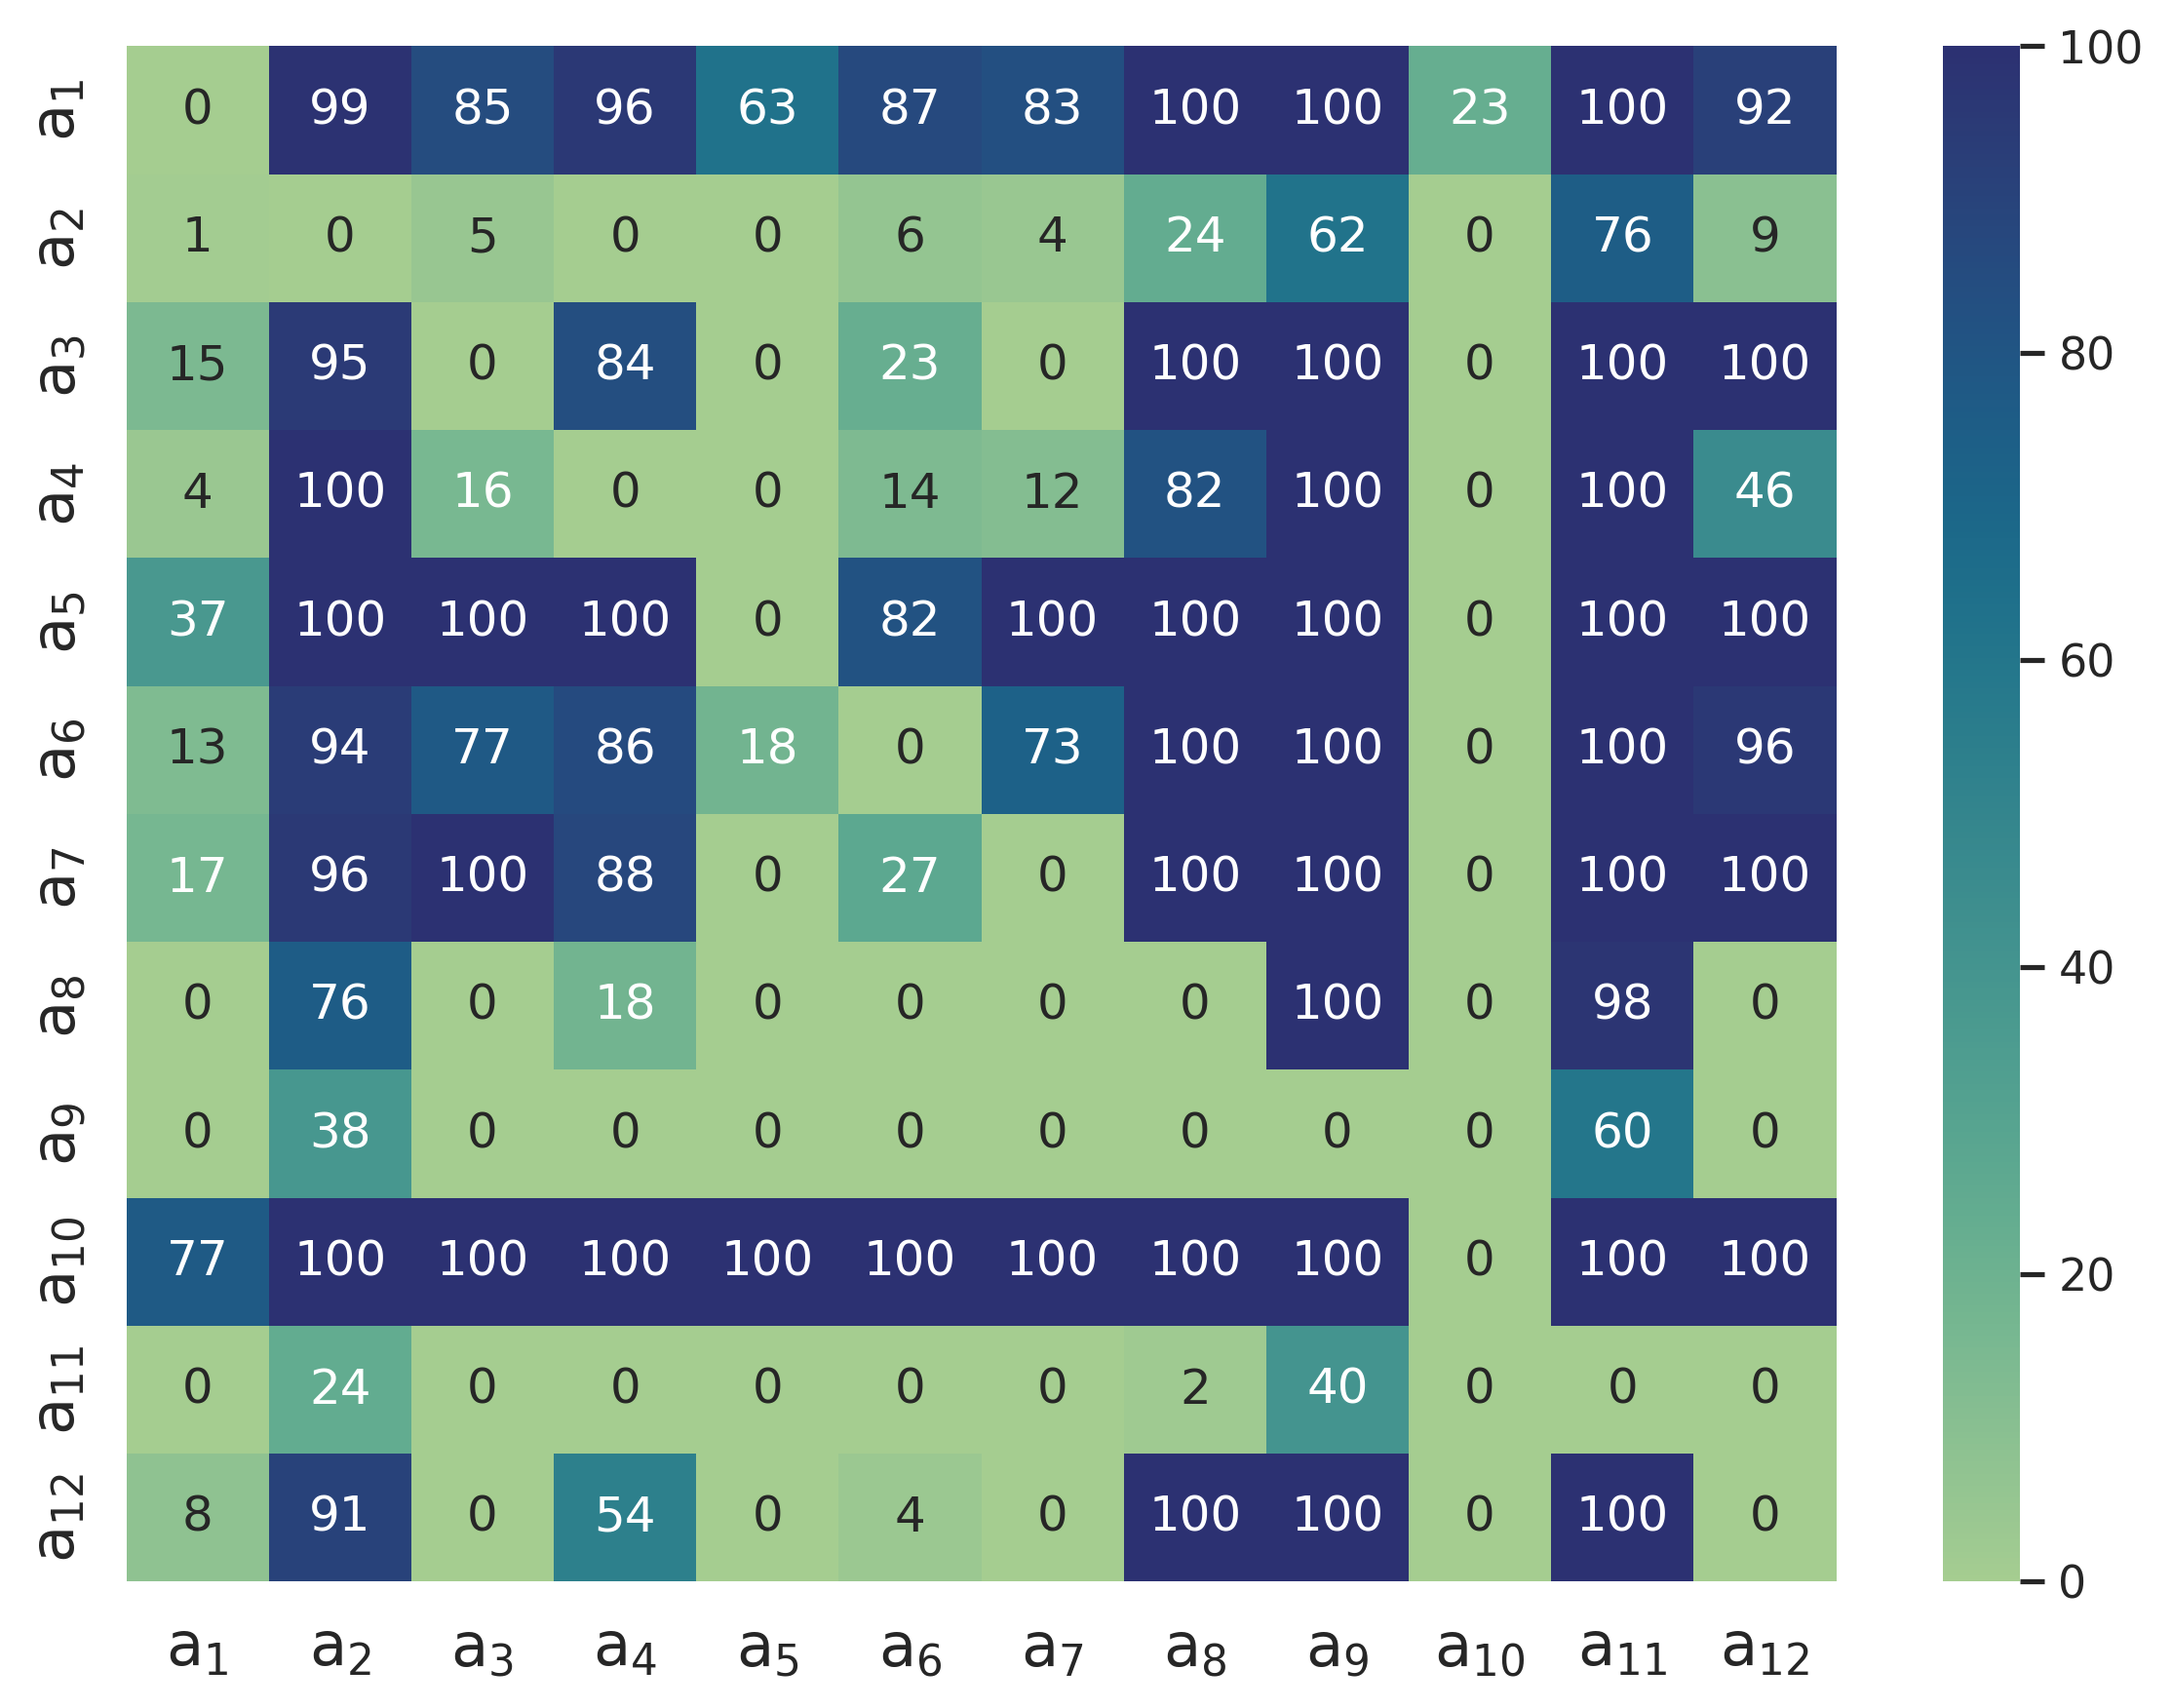

In [46]:
for n in [2, 3]:
    
    # Calculations
    pca = get_methods(n)["PCA"]
    transformed_data = pca.fit_transform(dataset.data)
    df_m = (
        pd.DataFrame(transformed_data, index=dataset.data.index, columns=range(n))
        .map(lambda x: f"{x:.4f}")
        .astype(np.float64)
    )    
    criteria = [Criterion(name, points=2) for name in df_m.columns]
    df_samples = calculate_samples(df_m, preferences[6][0], criteria)
    df_pwi = calculate_pwi(df_m, df_samples)

    # Calculation of the metric
    df_pwi_safe = np.where(df_pwi == 0, 1e-10, df_pwi)  # so there won't be a 0 passed to the log function
    df_f_pwi = (-df_pwi * np.log2(df_pwi_safe)).round(4).fillna(0.0)
    f_pwi = df_f_pwi.sum().sum() / (len(df_f_pwi) * (len(df_f_pwi) - 1))
    print(f"For {n} and PCA f_PWI = {f_pwi}")

    # Plotting
    df_pwi = df_pwi*100
    plt.figure(figsize=(8, 6), dpi=300)
    df_pwi.index = convert_index_to_latex(df_pwi.index)
    df_pwi.columns = convert_index_to_latex(df_pwi.index)
    sns.heatmap(df_pwi, annot=True, fmt=".0f", cmap="crest")
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.tight_layout()
    
    path = Path("../data/insulating-materials/output-dataset/preferences_6/plots/pwi")
    path.mkdir(exist_ok=True)
    plt.savefig(path / f"{n}dim_PCA")
    
    plt.show()

# Visualization of RAI

For 2 and PCA f_RAI = 0.8359833333333333


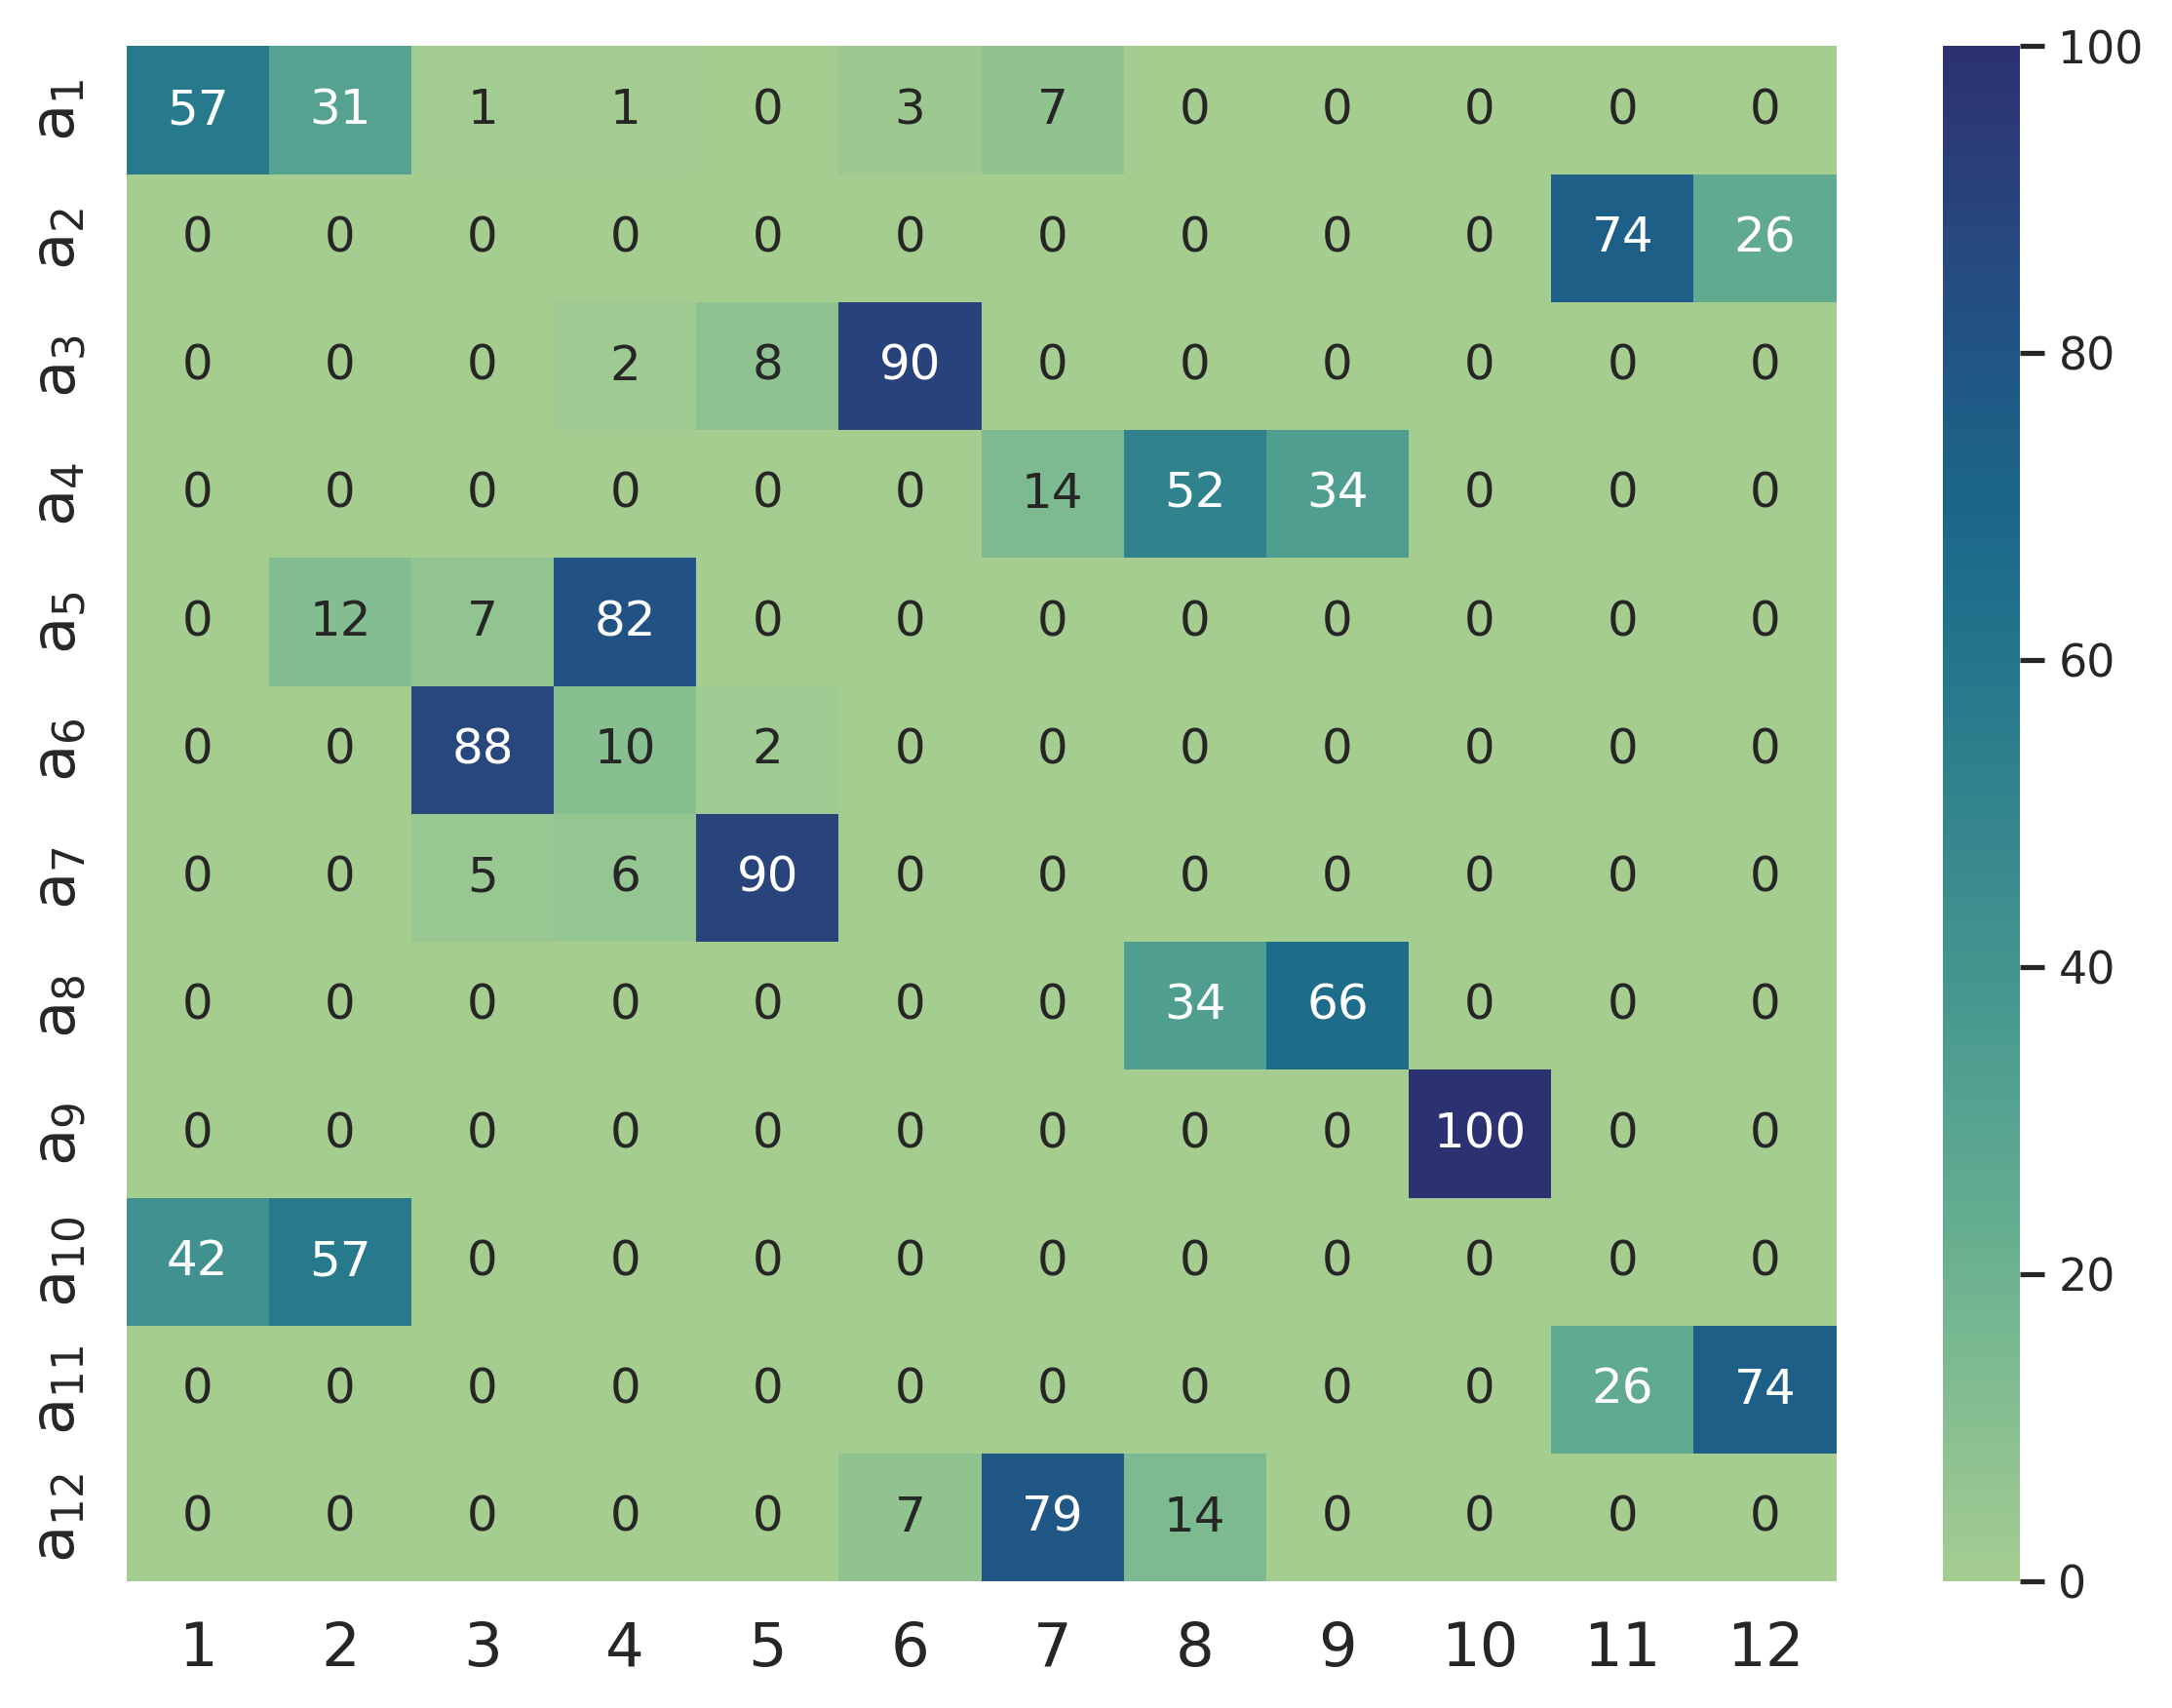

For 3 and PCA f_RAI = 1.6901583333333334


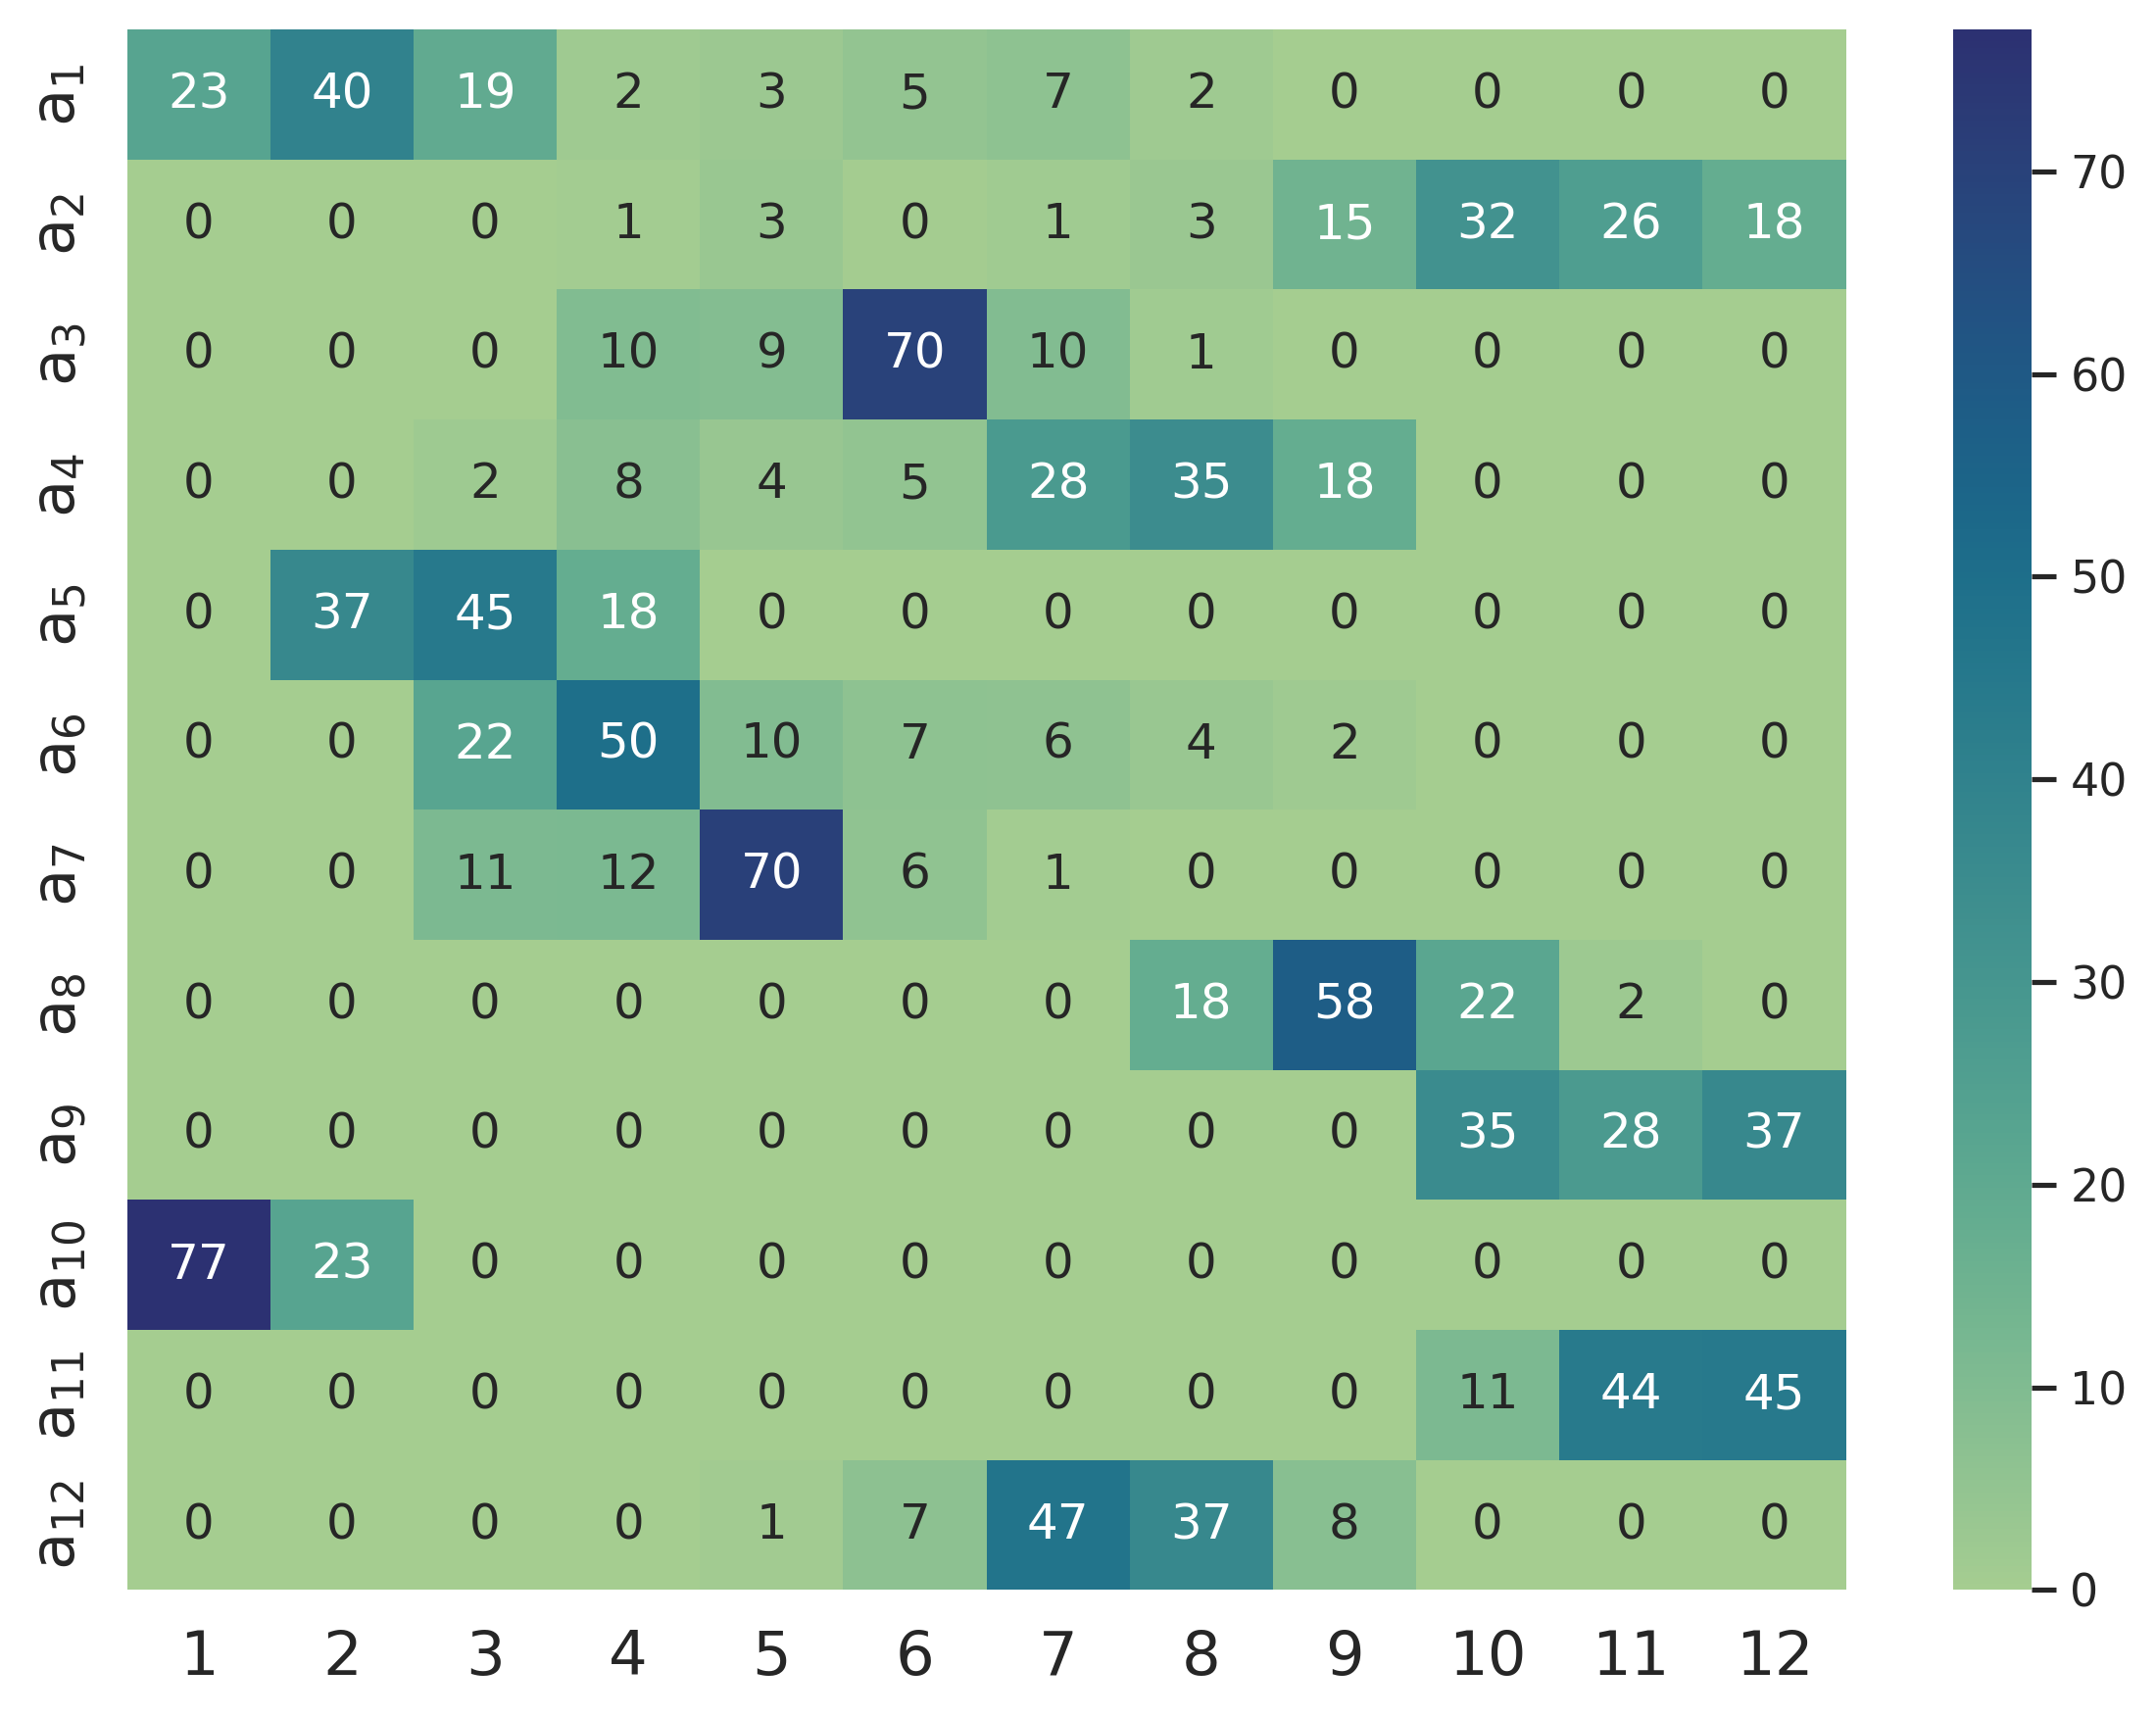

In [47]:
for n in [2, 3]:
    
    # Calculations
    pca = get_methods(n)["PCA"]
    transformed_data = pca.fit_transform(dataset.data)
    df_m = (
        pd.DataFrame(transformed_data, index=dataset.data.index, columns=range(n))
        .map(lambda x: f"{x:.4f}")
        .astype(np.float64)
    )    
    criteria = [Criterion(name, points=2) for name in df_m.columns]
    df_samples = calculate_samples(df_m, preferences[6][0], criteria)
    df_rai = calculate_rai(df_m, df_samples)

    # Calculation of the metric
    df_rai_safe = np.where(df_rai == 0, 1e-10, df_rai)
    df_f_rai = (-df_rai * np.log2(df_rai_safe)).round(4).fillna(0.0)
    f_rai = (df_f_rai.sum(axis=1) / len(df_f_rai)).sum()
    print(f"For {n} and PCA f_RAI = {f_rai}")

    # Plotting
    df_rai = df_rai*100
    plt.figure(figsize=(8, 6), dpi=300)
    df_rai.index = convert_index_to_latex(df_rai.index)
    sns.heatmap(df_rai, annot=True, fmt=".0f", cmap="crest")
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    
    path = Path("../data/insulating-materials/output-dataset/preferences_6/plots/rai")
    path.mkdir(exist_ok=True)
    plt.savefig(path / f"{n}dim_PCA")
    
    plt.show()

# Regions of Italy dataset

In [48]:
dataset = MCDADataset.read_csv("../data/regions-italy/dataset.csv")
df = dataset.data

In [49]:
def is_dominating(a_values, b_values) -> bool:
    return all(a >= b for a, b in zip(a_values, b_values)) and any(a > b for a, b in zip(a_values, b_values))


domination_org = []
for alt_1 in df.index:
    for alt_2 in df.index:
        if alt_1 == alt_2:
            continue

        if is_dominating(df.loc[alt_1, :].tolist(), df.loc[alt_2, :].tolist()):
            # print(alt_1, " > ", alt_2)
            domination_org.append((alt_1, alt_2))

print(f"Oryginalnie wszystkich dominacji: {len(domination_org)}")

data = defaultdict(list)
for n in range(2, 5):
    methods = get_methods(n)
    for method_name, method in methods.items():
        df_m = pd.DataFrame(method.fit_transform(df), index=df.index, columns=[f"Dim {i + 1}" for i in range(n)])
        counter = 0
        for alt_1, alt_2 in domination_org:
            if is_dominating(df_m.loc[alt_1, :].tolist(), df_m.loc[alt_2, :].tolist()):
                # print("!!!", alt_1, " > ", alt_2)
                counter += 1
        data[method_name].append(counter)
data["dimensions"] = range(2, 5)
df_domination = pd.DataFrame(data)

Oryginalnie wszystkich dominacji: 17


In [50]:
df_domination = df_domination.melt(id_vars="dimensions", value_vars=list(methods.keys()), var_name="Method", value_name="dominations")

In [51]:
for n in df_domination["dimensions"].unique():
    plt.figure(dpi=300)
    ax = sns.barplot(df_domination[df_domination["dimensions"] == n], x="Method", y="dominations", hue="Method", palette="colorblind", legend=False)
    for container in ax.containers:
        ax.bar_label(container, fontsize=13)
    plt.xlabel("")
    plt.yticks(list(range(1, len(domination_org)+1, 2)))
    plt.tight_layout()
    path = Path("../data/regions-italy/dominations")
    path.mkdir(exist_ok=True)
    plt.savefig(path / f"dim_{n}")
    plt.close()
    plt.show()

## Original diagram (five preferences)

In [30]:
# preference = [('a20', 'a16'), ('a15', 'a13'), ('a18', 'a2'), ('a19', 'a5'), ('a18', 'a7')]
preference = [('a9', 'a7'), ('a8', 'a6'), ('a18', 'a8'), ('a13', 'a8'), ('a17', 'a3')]

number_of_preference = len(preference)
df_utagms = calculate_uta_gms(dataset.data, preference, dataset.criteria)
np.fill_diagonal(df_utagms.values, 0)
print(f"Original dataset f_NEC = {df_utagms.sum().sum()}")
dot = hasse_graphviz(df_utagms.values)
dot.graph_attr.update(dpi="300")

# Color the preference edges
for source, target in preference:
    source_node = f"node{source[1:]}"
    target_node = f"node{target[1:]}"
    dot.edge(source_node, target_node, color="red")

# Color the domination edges
for source, target in domination_org:
    source_node = f"node{source[1:]}"
    target_node = f"node{target[1:]}"
    dot.edge(source_node, target_node, color="green")    

dot.render(
    filename="original",
    directory=f"../data/regions-italy/output-dataset/preferences_{number_of_preference}/diagrams",
    format="png",
    cleanup=True,
)

Original dataset f_NEC = 104


'../data/regions-italy/output-dataset/preferences_5/diagrams/original.png'

In [28]:
for n in [2, 3, 4]:
    methods = get_methods(n)
    for method_name, method in methods.items():
        transformed_data = method.fit_transform(dataset.data)
        df_m = (
            pd.DataFrame(transformed_data, index=dataset.data.index, columns=range(n))
            .map(lambda x: f"{x:.4f}")
            .astype(np.float64)
        )
        criteria = [Criterion(name, points=2) for name in df_m.columns]
        df_utagms = calculate_uta_gms(df_m, preference, criteria)
        np.fill_diagonal(df_utagms.values, 0)
        print(f"Dimensions {n}, {method_name}, f_NEC = {df_utagms.sum().sum()}")
        dot = hasse_graphviz(df_utagms.values)
        dot.graph_attr.update(dpi="300")            
        dot.render(
            filename=method_name,
            directory=f"../data/regions-italy/output-dataset/preferences_{number_of_preference}/diagrams/dim_{n}",
            format="png",
            cleanup=True,
        )

Dimensions 2, PCA, f_NEC = 158
Dimensions 2, KernelPCA, f_NEC = 167
Dimensions 2, Isomap, f_NEC = 165
Dimensions 2, MVU, f_NEC = 136
Dimensions 2, DAE, f_NEC = 170
Dimensions 3, PCA, f_NEC = 147
Dimensions 3, KernelPCA, f_NEC = 106
Dimensions 3, Isomap, f_NEC = 140
Dimensions 3, MVU, f_NEC = 123
Dimensions 3, DAE, f_NEC = 146
Dimensions 4, PCA, f_NEC = 138
Dimensions 4, KernelPCA, f_NEC = 99
Dimensions 4, Isomap, f_NEC = 111
Dimensions 4, MVU, f_NEC = 73
Dimensions 4, DAE, f_NEC = 127


## Original f_ERA

In [33]:
preferences = [[('a9', 'a6'), ('a17', 'a14'), ('a18', 'a6'), ('a10', 'a6'), ('a3', 'a11')], [('a19', 'a8'), ('a16', 'a10'), ('a17', 'a3'), ('a4', 'a7'), ('a8', 'a6')], [('a20', 'a16'), ('a15', 'a13'), ('a18', 'a2'), ('a19', 'a5'), ('a18', 'a7')], [('a9', 'a7'), ('a8', 'a6'), ('a18', 'a8'), ('a13', 'a8'), ('a17', 'a3')], [('a20', 'a17'), ('a14', 'a10'), ('a2', 'a11'), ('a20', 'a8'), ('a19', 'a4')], [('a14', 'a11'), ('a17', 'a18'), ('a16', 'a9'), ('a12', 'a1'), ('a12', 'a18')], [('a17', 'a2'), ('a16', 'a10'), ('a4', 'a5'), ('a13', 'a14'), ('a2', 'a11')], [('a4', 'a7'), ('a16', 'a9'), ('a19', 'a3'), ('a16', 'a10'), ('a11', 'a6')], [('a20', 'a13'), ('a3', 'a1'), ('a17', 'a11'), ('a18', 'a10'), ('a20', 'a2')], [('a2', 'a9'), ('a1', 'a7'), ('a20', 'a1'), ('a13', 'a10'), ('a2', 'a4')]]

f_eras = []
for preference in preferences:
    df_extreme = calculate_extreme_ranking(df_m, preference, criteria)
    df_extreme = df_extreme.reset_index(names=["label"])
    df_extreme["range_length"] = df_extreme["worst"] - df_extreme["best"]
    df_extreme.sort_index(ascending=False, inplace=True)
    f_eras.append((df_extreme["worst"] - df_extreme["best"]).mean())
print(sum(f_eras)/len(f_eras))

6.56


## time comparison

In [26]:
import time

for name, method in get_methods(2).items():
    s = time.perf_counter()
    df_m = pd.DataFrame(method.fit_transform(dataset.data), index=df.index, columns=[f"Dim {i + 1}" for i in range(2)])
    e = time.perf_counter()
    print(f"method {name}: {e-s}")

method PCA: 0.004947125038597733
method KernelPCA: 0.0037225840496830642
method Isomap: 0.003976000007241964
method MVU: 0.07726829202147201
method DAE: 2.5511097929556854


# Countries resilience

In [128]:
dataset = MCDADataset.read_csv("../data/countries-resilience/dataset.csv")
df = dataset.data

In [129]:
domination_org = []
for alt_1 in df.index:
    for alt_2 in df.index:
        if alt_1 == alt_2:
            continue

        if is_dominating(df.loc[alt_1, :].tolist(), df.loc[alt_2, :].tolist()):
            # print(alt_1, " > ", alt_2)
            domination_org.append((alt_1, alt_2))

print(f"Oryginalnie wszystkich dominacji: {len(domination_org)}")

data = defaultdict(list)
for n in range(2, 8):
    methods = get_methods(n)
    for method_name, method in methods.items():
        df_m = pd.DataFrame(method.fit_transform(df), index=df.index, columns=[f"Dim {i + 1}" for i in range(n)])
        counter = 0
        for alt_1, alt_2 in domination_org:
            if is_dominating(df_m.loc[alt_1, :].tolist(), df_m.loc[alt_2, :].tolist()):
                # print("!!!", alt_1, " > ", alt_2)
                counter += 1
        data[method_name].append(counter)
data["dimensions"] = range(2, 8)
df_domination = pd.DataFrame(data)

Oryginalnie wszystkich dominacji: 226


In [130]:
df_domination = df_domination.melt(id_vars="dimensions", value_vars=list(methods.keys()), var_name="Method", value_name="dominations")

In [132]:
for n in df_domination["dimensions"].unique():
    plt.figure(dpi=300)
    ax = sns.barplot(df_domination[df_domination["dimensions"] == n], x="Method", y="dominations", hue="Method", palette="colorblind", legend=False)
    for container in ax.containers:
        ax.bar_label(container, fontsize=13)
    plt.xlabel("")
    plt.yticks(list(range(0, len(domination_org)+10, 20)))
    plt.tight_layout()
    path = Path("../data/countries-resilience/dominations")
    path.mkdir(exist_ok=True)
    plt.savefig(path / f"dim_{n}")
    plt.close()
    # plt.show()

## heuristics for the original dataset

In [6]:
preferences = [[('Iran', 'Egypt'), ('Ireland', 'Benin'), ('Gabon', 'Nigeria'), ('Lithuania', 'Moldova'), ('Guatemala', 'Haiti'), ('Panama', 'Turkey'), ('India', 'Turkmenistan'), ('Togo', 'Angola'), ('Italy', 'Thailand'), ('Denmark', 'Argentina')], [('Uruguay', 'Senegal'), ('Luxembourg', 'El Salvador'), ('Chile', 'Indonesia'), ('Chile', 'Mongolia'), ('Germany', 'Japan'), ('Slovenia', 'Ukraine'), ('Luxembourg', 'Thailand'), ('Croatia', 'Congo. Rep.'), ('Switzerland', 'Iran'), ('Botswana', 'Iraq')], [('Slovenia', 'Yemen'), ('Italy', 'Bangladesh'), ('Saudi Arabia', 'South Sudan'), ('United Arab Emirates', 'Russia'), ('Greece', 'Uzbekistan'), ('Costa Rica', 'Algeria'), ('Oman', 'Egypt'), ('Sweden', 'Thailand'), ('Uruguay', 'Yemen'), ('Argentina', 'South Africa')], [('Estonia', 'Kuwait'), ('Panama', 'Peru'), ('United Arab Emirates', 'Algeria'), ('Guatemala', 'Egypt'), ('Malaysia', 'Trinidad and Tobago'), ('Gabon', 'Niger'), ('Sweden', 'South Sudan'), ('Lithuania', 'Algeria'), ('Denmark', 'Bosnia and Herzegovina'), ('Bulgaria', 'Bangladesh')], [('Italy', 'Russia'), ('Austria', 'Sudan'), ('Suriname', 'Vietnam'), ('Spain', 'Bangladesh'), ('New Zealand', 'Bolivia'), ('New Zealand', 'Myanmar'), ('Kyrgyzstan', 'Eritrea'), ('United Arab Emirates', 'Indonesia'), ('United States of America', 'Haiti'), ('Lithuania', 'Argentina')], [('Colombia', 'Egypt'), ('Nepal', 'Honduras'), ('Argentina', 'Russia'), ('Costa Rica', 'Benin'), ('Costa Rica', 'Kenya'), ('Austria', 'Lithuania'), ('Portugal', 'Uzbekistan'), ('Norway', 'Turkey'), ('Mauritius', 'Saudi Arabia'), ('Albania', 'Pakistan')], [('Hong Kong', 'Estonia'), ('Argentina', 'South Sudan'), ('Costa Rica', 'Ukraine'), ('Estonia', 'Bangladesh'), ('Bulgaria', 'Azerbaijan'), ('Malaysia', 'Algeria'), ('Mozambique', 'Cameroon'), ('Gabon', "Cote d'Ivoire"), ('North Korea', 'Egypt'), ('Austria', 'Spain')], [('Finland', 'Armenia'), ('Qatar', 'Haiti'), ('Israel', 'Syrian Arab Republic'), ('Bulgaria', 'India'), ('Chile', 'Malaysia'), ('Senegal', 'Haiti'), ('Guatemala', 'Kosovo'), ('Italy', 'Eritrea'), ('Morocco', 'Egypt'), ('Peru', 'Egypt')], [('New Zealand', 'Pakistan'), ('Switzerland', 'Morocco'), ('Lithuania', 'South Sudan'), ('Austria', 'Azerbaijan'), ('Netherlands', 'Hong Kong'), ('Israel', 'Eritrea'), ('Slovakia', 'Lebanon'), ('Ethiopia', 'Cameroon'), ('Norway', 'Czech Republic'), ('Costa Rica', 'Togo')], [('Italy', 'Bulgaria'), ('Slovenia', 'Mexico'), ('Netherlands', 'South Korea'), ('Austria', 'Togo'), ('New Zealand', 'Mauritius'), ('South Korea', 'Israel'), ('Chile', 'Bahrain'), ('Panama', 'Libya'), ('Switzerland', 'Uzbekistan'), ('Brunei Darussalam', 'Trinidad and Tobago')]]

In [8]:
original_f = []
for preference in preferences:
    f_nec, f_era, f_pwi, f_rai = calculate_heuristics(
        dataset.data,
        preference,
        dataset.criteria,
        era=False
    )
    original_f.append((f_nec, f_era, f_pwi, f_rai))
    print(f_nec, f_era, f_pwi, f_rai)

2151 None 0.11786252826310381 4.984617142857142
1865 None 0.11998450668036997 5.05255
1373 None 0.11386632579650567 4.975065714285714
1245 None 0.12424429085303186 5.098687142857143
2382 None 0.10130340184994864 4.830316428571429
2445 None 0.09732644398766702 4.728897857142858
2384 None 0.10392154162384379 4.833187857142857
2026 None 0.11357855087358683 4.949052142857143
1307 None 0.12319359712230217 5.047182857142857
1946 None 0.11418856628982528 4.969754285714284


In [15]:
for x in zip(*original_f):
    if any([b is None for b in x]):
        continue
    print(sum(x)/len(x))

1912.4
0.1129469753340185
4.946931142857143


## time comparison

In [21]:
import time

for name, method in get_methods(2).items():
    s = time.perf_counter()
    df_m = pd.DataFrame(method.fit_transform(dataset.data), index=df.index, columns=[f"Dim {i + 1}" for i in range(2)])
    e = time.perf_counter()
    print(f"method {name}: {e-s}")

method PCA: 0.006520125025417656
method KernelPCA: 0.006422624981496483
method Isomap: 0.011332666967064142
method MVU: 4.011592835013289
method DAE: 18.84698509197915


# Designs

In [27]:
dataset = MCDADataset.read_csv("../data/designs/dataset.csv")
df = dataset.data

In [31]:
import time

for name, method in get_methods(2).items():
    if name == "MVU":
        continue
    s = time.perf_counter()
    df_m = pd.DataFrame(method.fit_transform(dataset.data), index=df.index, columns=[f"Dim {i + 1}" for i in range(2)])
    e = time.perf_counter()
    print(f"method {name}: {e-s}")

method PCA: 0.006461374985519797
method KernelPCA: 0.0072745829820632935
method Isomap: 0.02484262501820922


/usr/local/lib/python3.12/site-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 6 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.12/site-pa

method DAE: 18.13173000799725


In [33]:
def is_dominating(a_values, b_values) -> bool:
    return all(a >= b for a, b in zip(a_values, b_values)) and any(a > b for a, b in zip(a_values, b_values))


domination_org = []
for alt_1 in df.index:
    for alt_2 in df.index:
        if alt_1 == alt_2:
            continue

        if is_dominating(df.loc[alt_1, :].tolist(), df.loc[alt_2, :].tolist()):
            # print(alt_1, " > ", alt_2)
            domination_org.append((alt_1, alt_2))

print(f"Oryginalnie wszystkich dominacji: {len(domination_org)}")

Oryginalnie wszystkich dominacji: 73


# Designs variants

/tmp/ipykernel_32861/1486577788.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_results = df_results.loc[idx["f_nec", 2], idx[:, 2]]


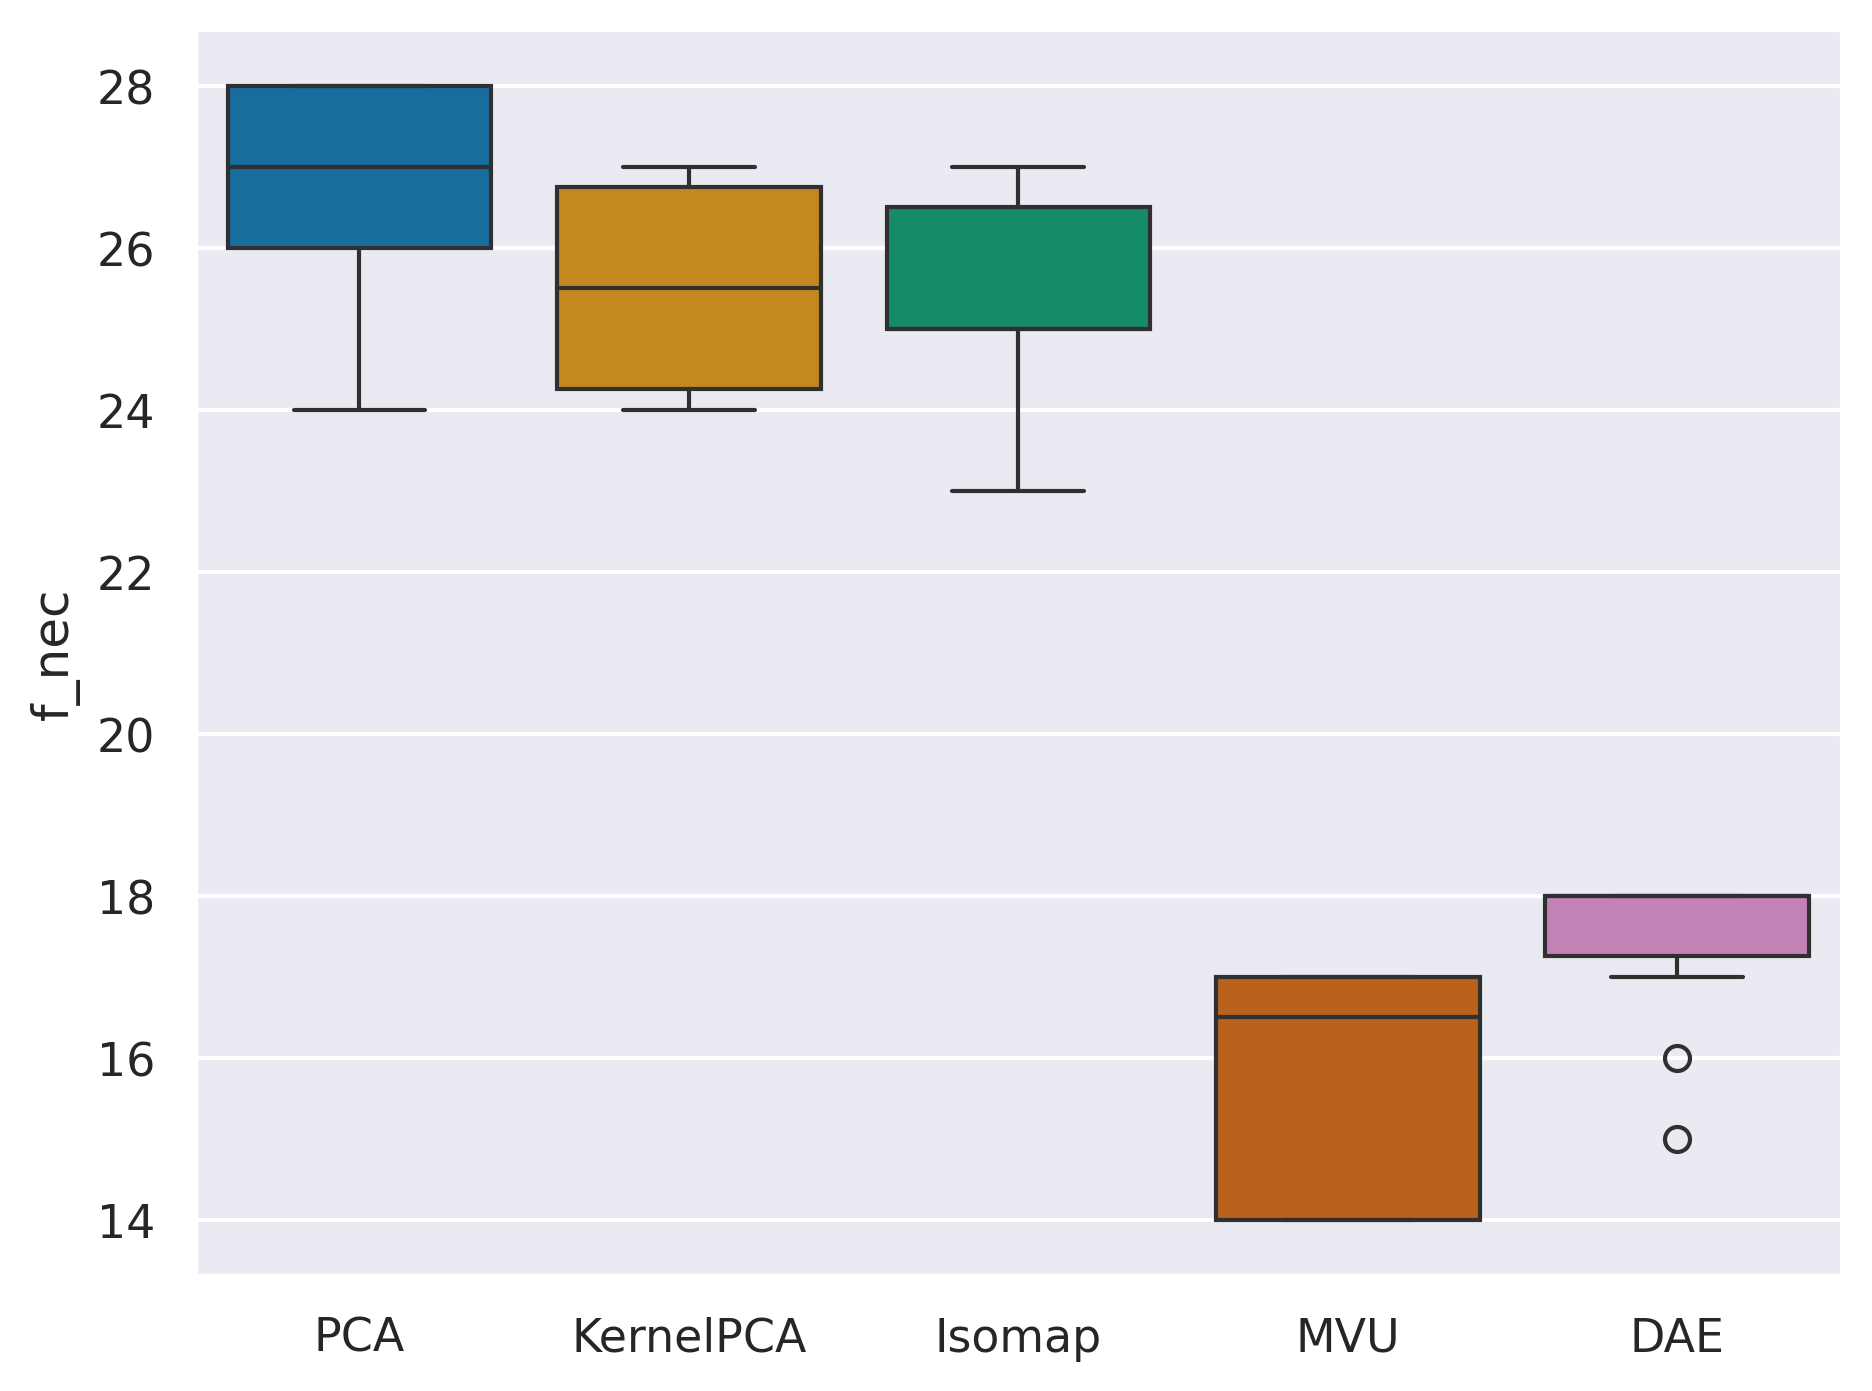

In [120]:
from plotting import read_results_data

df_results = read_results_data("../data/design-variants/output-dataset/preferences_6")
idx = pd.IndexSlice
df_results = df_results.loc[idx["f_nec", 2], idx[:, 2]]
methods = df_results.columns.get_level_values(0).unique()
df_results.columns = methods
df_results.reset_index(inplace=True, drop=True)
df_melted = df_results.melt(value_vars=methods, var_name="method", value_name="f_nec")

order = ["PCA", "KernelPCA", "Isomap", "MVU", "DAE"]
plt.figure(dpi=300)
sns.boxplot(df_melted, x="method", y="f_nec", palette="colorblind", hue="method", legend=False, order=order, hue_order=order)
plt.xlabel("")
plt.tight_layout()
plt.savefig("../data/design-variants/output-dataset/preferences_6/plots/boxplot.png")
plt.show()

# Building

In [121]:
from plotting import read_results_data

idx = pd.IndexSlice
metric = "f_pwi"

for dim in [2, 3]:
    df_results = read_results_data("../data/building/output-dataset/preferences_6")
    df_results = df_results.loc[idx[metric, 2], idx[:, dim]]
    methods = df_results.columns.get_level_values(0).unique()
    df_results.columns = methods
    df_results.reset_index(inplace=True, drop=True)
    df_melted = df_results.melt(value_vars=methods, var_name="method", value_name=metric)
    
    order = ["PCA", "KernelPCA", "Isomap", "MVU", "DAE"]
    plt.figure(dpi=300)
    sns.boxplot(df_melted, x="method", y=metric, palette="colorblind", hue="method", legend=False, order=order, hue_order=order)
    plt.xlabel("")
    plt.tight_layout()
    plt.savefig(f"../data/building/output-dataset/preferences_6/plots/boxplot_{dim}.png")
    plt.close()
    # plt.show()

/tmp/ipykernel_32861/3217284297.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_results = df_results.loc[idx[metric, 2], idx[:, dim]]
/tmp/ipykernel_32861/3217284297.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_results = df_results.loc[idx[metric, 2], idx[:, dim]]


# Mortars

In [122]:
from plotting import read_results_data

idx = pd.IndexSlice
metric = "f_era"

for dim in [2, 3]:
    df_results = read_results_data("../data/cement-mortars-geopolymers/output-dataset/preferences_6")
    df_results = df_results.loc[idx[metric, 2], idx[:, dim]]
    methods = df_results.columns.get_level_values(0).unique()
    df_results.columns = methods
    df_results.reset_index(inplace=True, drop=True)
    df_melted = df_results.melt(value_vars=methods, var_name="method", value_name=metric)
    
    order = ["PCA", "KernelPCA", "Isomap", "MVU", "DAE"]
    plt.figure(dpi=300)
    sns.boxplot(df_melted, x="method", y=metric, palette="colorblind", hue="method", legend=False, order=order, hue_order=order)
    plt.xlabel("")
    plt.tight_layout()
    plt.savefig(f"../data/cement-mortars-geopolymers/output-dataset/preferences_6/plots/boxplot_{dim}.png")
    plt.close()
    # plt.show()

/tmp/ipykernel_32861/3335098519.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_results = df_results.loc[idx[metric, 2], idx[:, dim]]
/tmp/ipykernel_32861/3335098519.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_results = df_results.loc[idx[metric, 2], idx[:, dim]]


# Synthethic

In [123]:
from plotting import read_results_data

idx = pd.IndexSlice
metric = "f_pwi"

dim = 2
for dataset in [20, 30, 40]:
    df_results = read_results_data(f"../data/insulating-materials/output-dataset{dataset}/preferences_6")
    df_results = df_results.loc[idx[metric, 2], idx[:, dim]]
    methods = df_results.columns.get_level_values(0).unique()
    df_results.columns = methods
    df_results.reset_index(inplace=True, drop=True)
    df_melted = df_results.melt(value_vars=methods, var_name="method", value_name=metric)
    
    order = ["PCA", "KernelPCA", "Isomap", "MVU", "DAE"]
    plt.figure(dpi=300)
    sns.boxplot(df_melted, x="method", y=metric, palette="colorblind", hue="method", legend=False, order=order, hue_order=order)
    plt.xlabel("")
    plt.tight_layout()
    plt.savefig(f"../data/insulating-materials/output-dataset{dataset}/preferences_6/plots/boxplot_{dim}.png")
    plt.close()
    # plt.show()

/tmp/ipykernel_32861/1826839123.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_results = df_results.loc[idx[metric, 2], idx[:, dim]]
/tmp/ipykernel_32861/1826839123.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_results = df_results.loc[idx[metric, 2], idx[:, dim]]
/tmp/ipykernel_32861/1826839123.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_results = df_results.loc[idx[metric, 2], idx[:, dim]]
